## Assignment 2: Classification
# Using Machine Learning Tools CS3317

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

Some of the parts of this assignment build on the workflow from the first assignment and that part of the course, and so less detailed instructions are provided for this, as you should be able to implement this workflow now without low-level guidance. A substantial portion of the marks for this assignment are associated with making the right choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and certain restrictions on sklearn functions will be made clear in the instruction text. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail, as appropriate to the marks given.

## 1. Investigate Dataset (10% = 3 marks)

In [1]:
# This code imports some libraries that you will need. 
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

### 1.1 Load the dataset [0.5 marks]
Do this from the csv file, `assignment2.csv`, as done in assignment 1 and workshops 2 and 3. Extract the feature names and label names for use later on.  Note that we will be treating the _malignant_ case as our _positive_ case, as this is the standard convention in medicine.

**Print out some information (in text) about the data, to verify that the loading has worked and to get a feeling for what is present in the dataset and the range of the values.**

**Also, graphically show the proportions of the labels in the whole dataset.**

In [2]:
# Your code here

# Read data from CSV
dataset = pd.read_csv('assignment2.csv')

# Some information (in text) about the data

# 1. Display dataset
display(dataset)

# 2. Display data range
display(dataset.describe().T)

# 3. Display data type
display(dataset.info())

# 4. Display number of na records
print("Check number of na records:")
display(dataset.isna().sum())

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,malignant,15.494654,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,19.522957,22.427276,135.128520,1286.903131,0.142725,0.407483,0.445992,0.171662,0.353211,0.097731
1,malignant,16.229871,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,19.140235,24.905156,123.886045,1234.499997,0.129135,0.223918,0.248846,0.136735,0.284427,0.085758
2,malignant,16.345671,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,19.144816,25.601433,125.113036,1202.749973,0.135017,0.314402,0.332505,0.161497,0.313038,0.084340
3,malignant,13.001009,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,15.565911,26.145119,102.958265,737.655082,0.161390,0.485912,0.430007,0.167254,0.432297,0.117705
4,malignant,16.416060,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,18.620376,22.306233,124.002529,1139.490971,0.133950,0.230996,0.316620,0.131715,0.269591,0.080497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,benign,14.048464,17.186671,90.974271,637.474225,0.094969,0.091549,0.063532,0.039494,0.173324,...,15.790651,22.538529,103.423320,819.408970,0.126466,0.206701,0.192139,0.095350,0.287380,0.078520
296,benign,12.879033,16.767790,83.123369,539.225356,0.092146,0.083986,0.059347,0.035404,0.167690,...,14.358919,21.955513,93.620160,684.694077,0.118165,0.191978,0.180949,0.083989,0.263879,0.078279
297,malignant,13.123052,18.793057,84.897717,555.002209,0.098036,0.090178,0.066586,0.043711,0.172389,...,14.991646,24.820718,97.933068,726.695117,0.126203,0.201766,0.202433,0.100361,0.256863,0.079667
298,benign,14.411991,18.970674,93.423809,671.128126,0.086304,0.090118,0.070882,0.039482,0.175789,...,16.555187,25.591332,108.978466,893.818250,0.120338,0.246945,0.236415,0.105354,0.280900,0.081828


,count,mean,std,min,25%,50%,75%,max
mean radius,300.0,14.231808,1.297393,11.560025,13.356676,13.976933,15.103078,19.090091
mean texture,300.0,19.312619,1.572224,15.349270,18.194791,19.220652,20.245660,26.836291
mean perimeter,300.0,92.727687,8.949937,74.690886,86.659535,90.896982,99.093762,126.168030
mean area,300.0,664.367372,129.515717,477.371592,580.383274,628.004851,737.444716,1300.788708
mean smoothness,300.0,0.096937,0.005067,0.084651,0.093305,0.096722,0.099995,0.114500
mean compactness,300.0,0.106615,0.020819,0.075184,0.091105,0.102401,0.117334,0.192880
mean concavity,300.0,0.092591,0.030312,0.050771,0.069071,0.084829,0.107994,0.212704
mean concave points,300.0,0.050820,0.014350,0.028701,0.039507,0.046744,0.060606,0.105212
mean symmetry,300.0,0.182546,0.010754,0.157059,0.175353,0.181685,0.187789,0.226448
mean fractal dimension,300.0,0.062841,0.002736,0.057830,0.060950,0.062477,0.064149,0.076091


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

None

Check number of na records:


label                      0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

List of feature names (30 items): ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

List of label names (2 items): ['benign', 'malignant']
benign       154
malignant    146
Name: label, dtype: int64


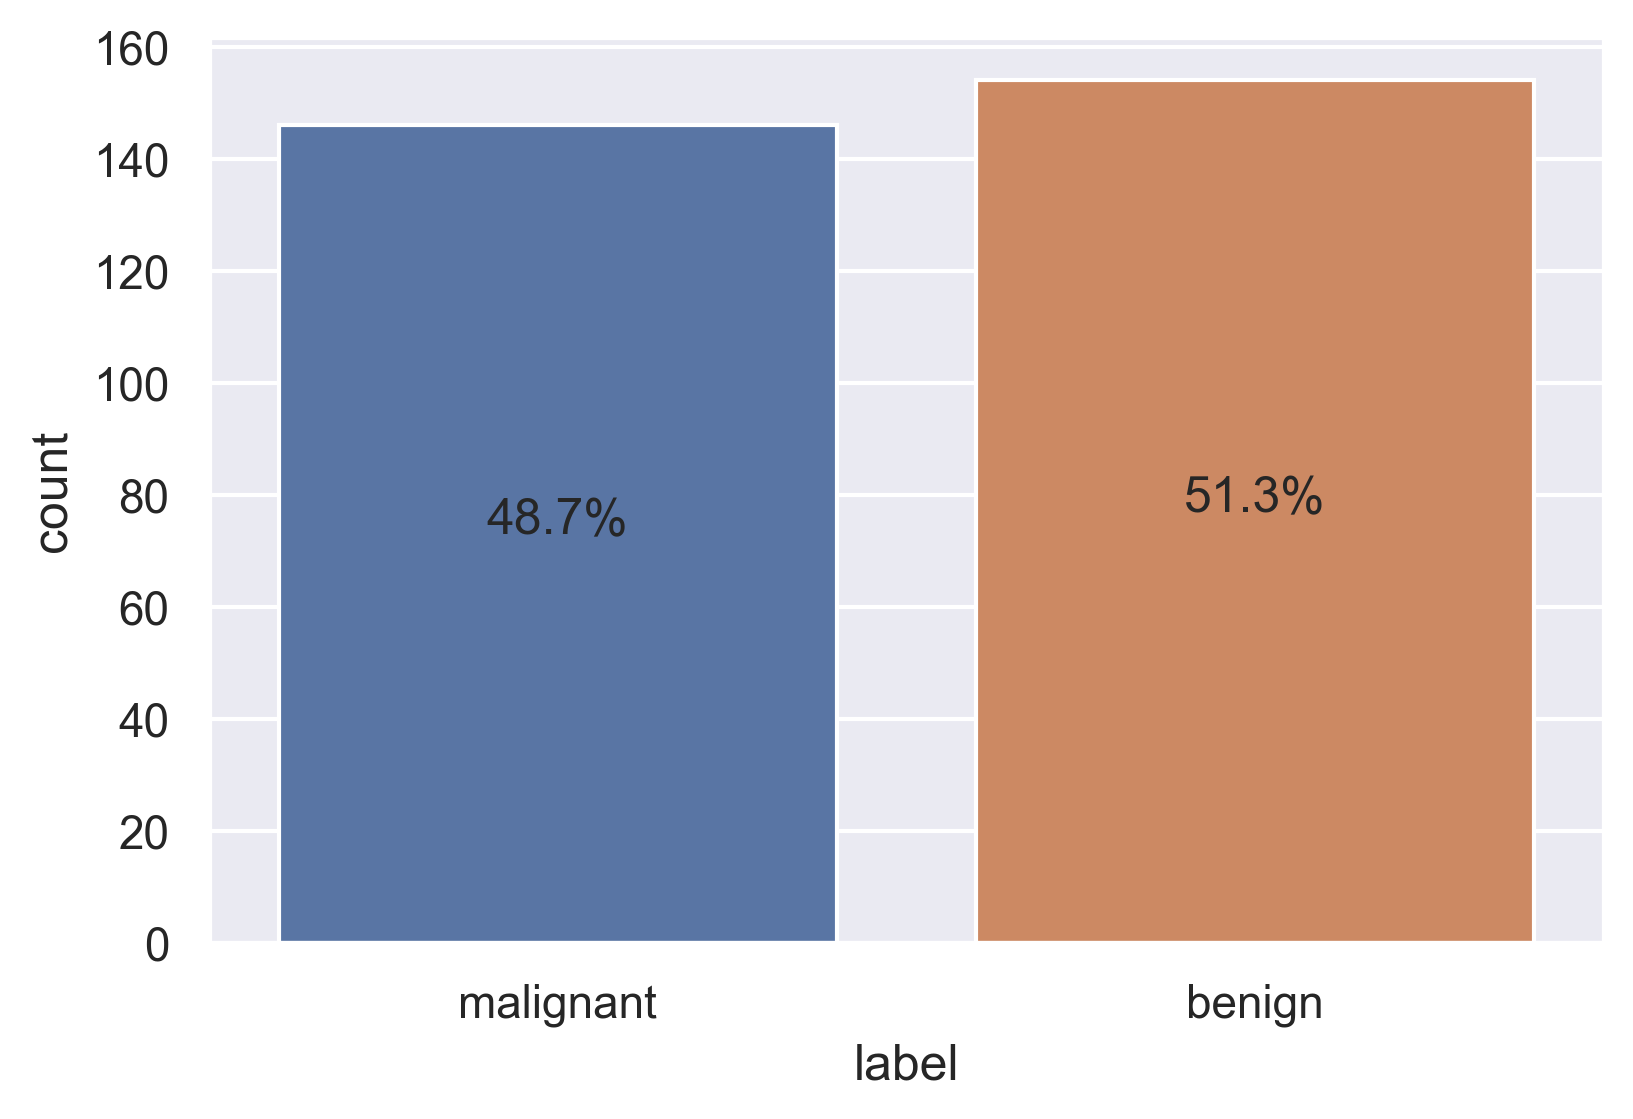

In [3]:
# Extract feature names
features = dataset.columns[1:].tolist()
print(f"List of feature names ({len(features)} items):", features)
print()

# Extract labels
label_value_counts = dataset['label'].value_counts()
labels = label_value_counts.index.tolist()
print(f"List of label names ({len(labels)} items):", labels)

# Print number of each labels
print(label_value_counts)

# Graphically show the proportions of the labels in the whole dataset.
plt.figure(dpi=300)
sns.set()

ax = sns.countplot(x=dataset['label'])

# Calculate percentage of each label and add percentage label in the figure
total = len(dataset)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()//2
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

### 1.2 Visualise the dataset [1.5 marks]

As this data is well curated by the client already, you do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - **display histograms** for each feature in the _mean_ group, but on _each_ histogram **have the two classes displayed together in one plot** (see example plot below and a code fragment to help you) - and note that your plot does not need to look exactly the example here;
 - **repeat this** for the _standard error_ and _worst_ groups;
 - make sure that in all cases you clearly label the plots and the classes in histograms.

<center><img src="Example_Hist_Plot.png" width="300" alt="Example plot of histogram"></center>

In [4]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
def plot_histograms(features, Nrows, Ncols):

    fig, axes = plt.subplots(Nrows, Ncols, figsize=(20, 10))

    for row in range(Nrows):
        for col in range(Ncols):
            feature = features[row*Ncols + col]
            sns.histplot(data=dataset, x=feature, hue="label", bins='auto', kde=True, ax=axes[row,col], edgecolor=None)

    plt.show()

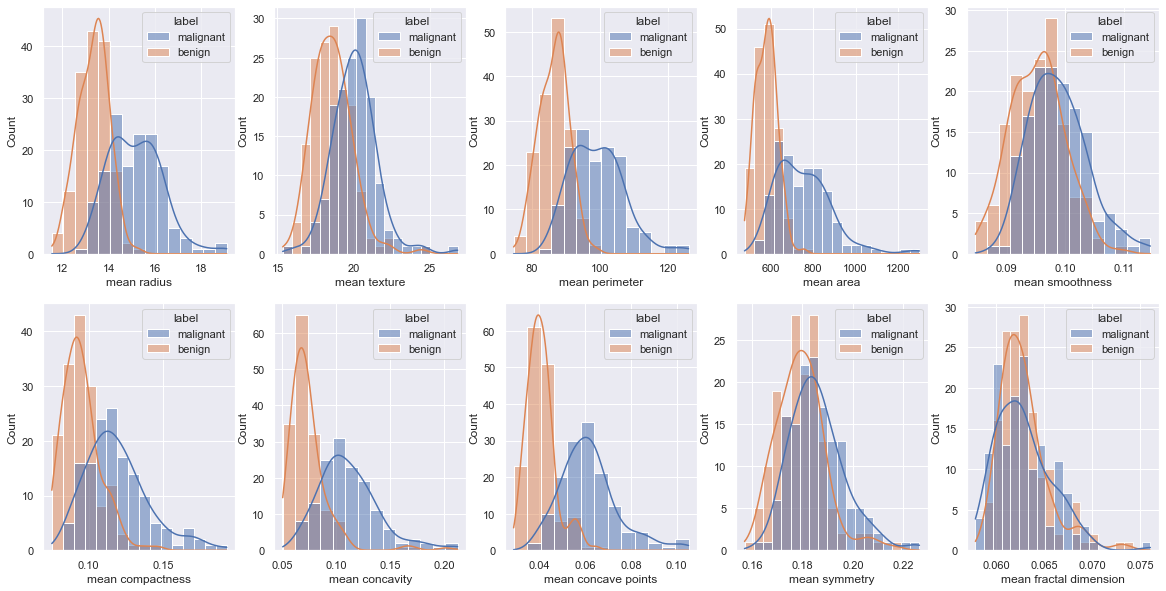

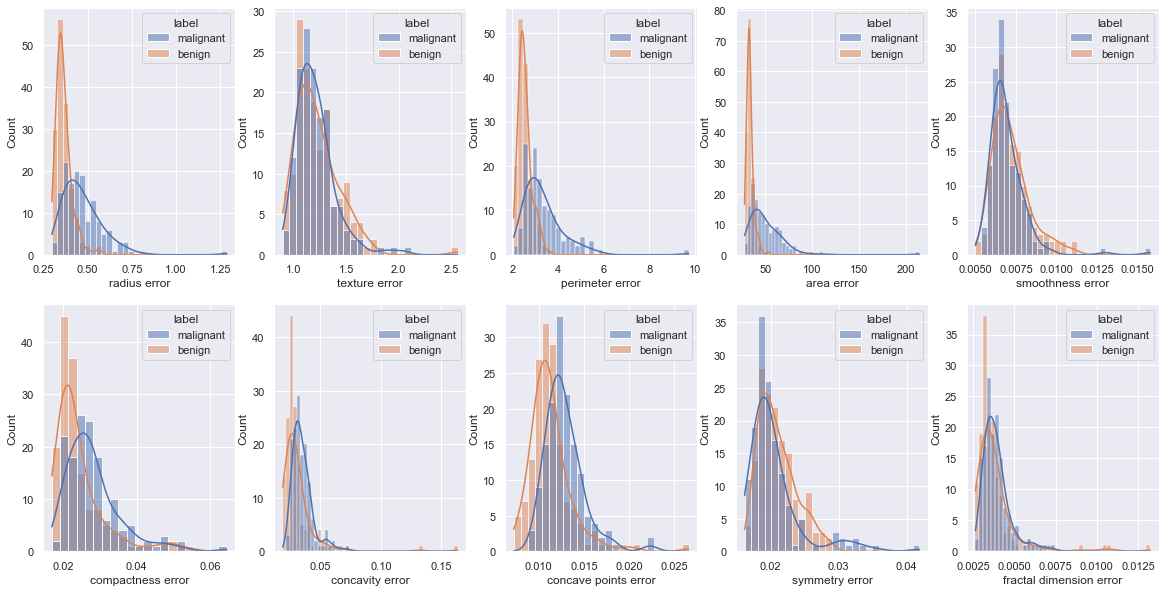

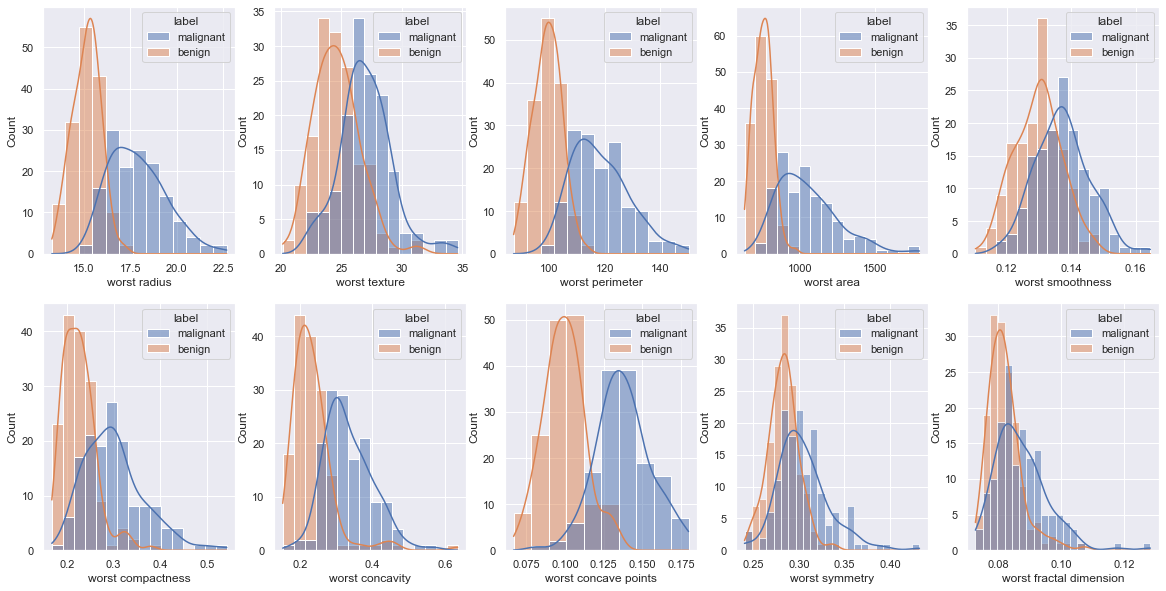

In [5]:
# Your code here
plot_histograms(features[:10], 2, 5)
plot_histograms(features[10:20], 2, 5)
plot_histograms(features[20:30], 2, 5)

### 1.3 Ranking the features [0.5 marks]

**Based on the histograms, which do you think are the 3 strongest features for discriminating between the classes?**

,Correlation to the target,Abs of correlation
label,1.000000,1.000000
worst concave points,0.778575,0.778575
worst perimeter,0.764033,0.764033
worst radius,0.755703,0.755703
mean concave points,0.729886,0.729886
mean perimeter,0.710967,0.710967
worst area,0.705986,0.705986
mean radius,0.698323,0.698323
mean area,0.664719,0.664719
mean concavity,0.623550,0.623550


<AxesSubplot:>

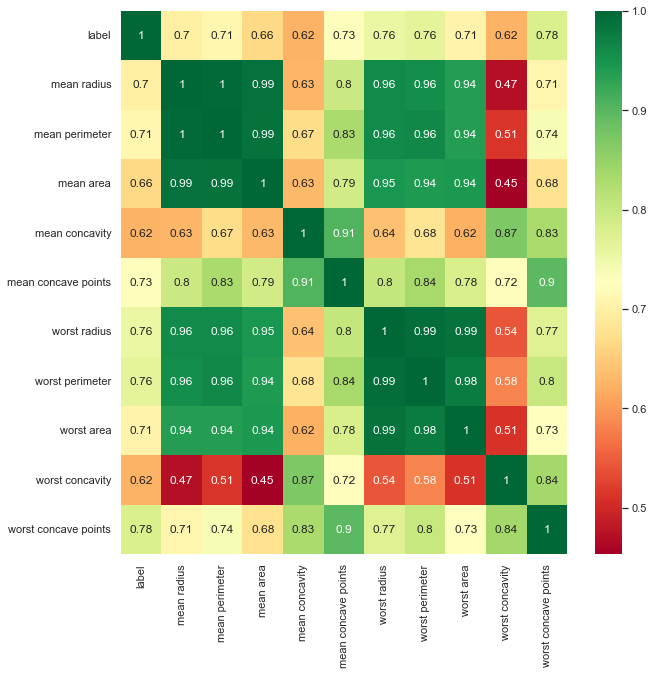

In [6]:
# Your answer here

# Convert label into 1 and 0. 
# Treating the malignant case as the positive case, as this is the standard convention in medicine.
dataset['label'].replace(
    ['malignant', 'benign'],
    [1, 0],
    inplace=True
)

# Show correlation between features and label
correlation = dataset.corr()

# Show correlation between top features (abs of correlation is greater than 0.6)
# Create dataframe of correlation matrix
df_correlation = pd.DataFrame(
    correlation.unstack().sort_values(ascending=False)['label'], 
    columns=['Correlation to the target']
)

# Create column 'Abs of correlation'
df_correlation['Abs of correlation'] = abs(df_correlation['Correlation to the target'])

# Sort by 'Abs of correlation'
df_correlation = df_correlation.sort_values(by='Abs of correlation', ascending=False, axis=0)

# Filter features with abs of correlation greater than 0.6
df_correlation = df_correlation.loc[df_correlation['Abs of correlation'] > 0.6]
display(df_correlation)

# Get top features
top_corr_features = correlation.index[abs(correlation["label"])>0.6]

# Show heatmap
plt.figure(figsize=(10,10))
sns.heatmap(dataset[top_corr_features].corr(), annot=True, cmap="RdYlGn")

Based on the correlation, the 3 strongest features for discriminating between the classes are:
1. worst concave points
2. worst perimeter
3. worst radius

This is because these 3 features have the highest correlation to the label.

### 1.4 Splitting the dataset [0.5 marks]

Split the dataset into appropriate subsets. You must choose what the subsets are and how big they are. However, we want to make sure the proportion of the two classes is consistent across all datasets, so use the _stratify_ option, as used in workshops 5 and 6. Verify the size and label distribution in each dataset.

In [7]:
# Your code here
from sklearn.model_selection import train_test_split

# Split dataset into training set, validation set and test set
bigtrain_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset['label'])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.2, random_state=42, stratify=bigtrain_set['label'])

In [8]:
X_train = train_set.drop("label",axis=1)
y_train = train_set["label"].copy()
X_test = test_set.drop("label",axis=1)
y_test = test_set["label"].copy()
X_val = val_set.drop("label",axis=1)
y_val = val_set["label"].copy()

print(f'Shape of the whole dataset: {dataset.shape}')
print()

print("Verify the size in each dataset")

print(f'\t1. Shape of the training dataset: {train_set.shape}')
print(f'\t2. Shape of the validation dataset: {val_set.shape}')
print(f'\t3. Shape of the test dataset: {test_set.shape}')

print()

print("Verify label distribution in each dataset")
print(f'\t1. Mean of label in training dataset: {np.mean(y_train)}')
print(f'\t2. Mean of label in validation dataset: {np.mean(y_val)}')
print(f'\t3. Mean of label in test dataset: {np.mean(y_test)}')

Shape of the whole dataset: (300, 31)

Verify the size in each dataset
	1. Shape of the training dataset: (192, 31)
	2. Shape of the validation dataset: (48, 31)
	3. Shape of the test dataset: (60, 31)

Verify label distribution in each dataset
	1. Mean of label in training dataset: 0.4895833333333333
	2. Mean of label in validation dataset: 0.4791666666666667
	3. Mean of label in test dataset: 0.48333333333333334


## 2. Build, Train and Optimise Classifiers (60% = 18 marks)

### 2.1 Pipeline [0.5 marks]
**Build a pre-processing pipeline** that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing.  

In [9]:
# Your code here
from sklearn.impute import SimpleImputer

preprocessing_pipeline = Pipeline([ 
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()) 
])

### 2.2 Baseline measurements [1.5 marks]

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Code is given below for the latter metrics (all metrics are discussed in lecture 4 and many are in workshop 4).

Also **calculate and display the confusion matrix** for each baseline case, using a heatmap and numbers (as in workshop 4). 

In [10]:
from sklearn.metrics import fbeta_score, make_scorer

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

In [11]:
# Your code here
from numpy.random import default_rng

# Generate random sample with equal probability for each class

# Default random generator
rng = default_rng()

# Generate a random series contains random indexes from y_val
indexes = rng.choice(y_val.shape[0], size=int(y_val.shape[0] / 2), replace=False)

# Create random y test
random_y_test = np.zeros(y_val.shape[0])

# Replace random index with 1
random_y_test[indexes] = 1

print(random_y_test)

[0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]


Case 1. Predicting all samples to be negative (class 1)

Balanced accuracy: 0.5
Recall: 0.0
Precision: 1.0
AUC: 0.5
F1 score: 0.0
Fbeta score with beta = 0.1: 0.0
Fbeta score with beta = 10: 0.0


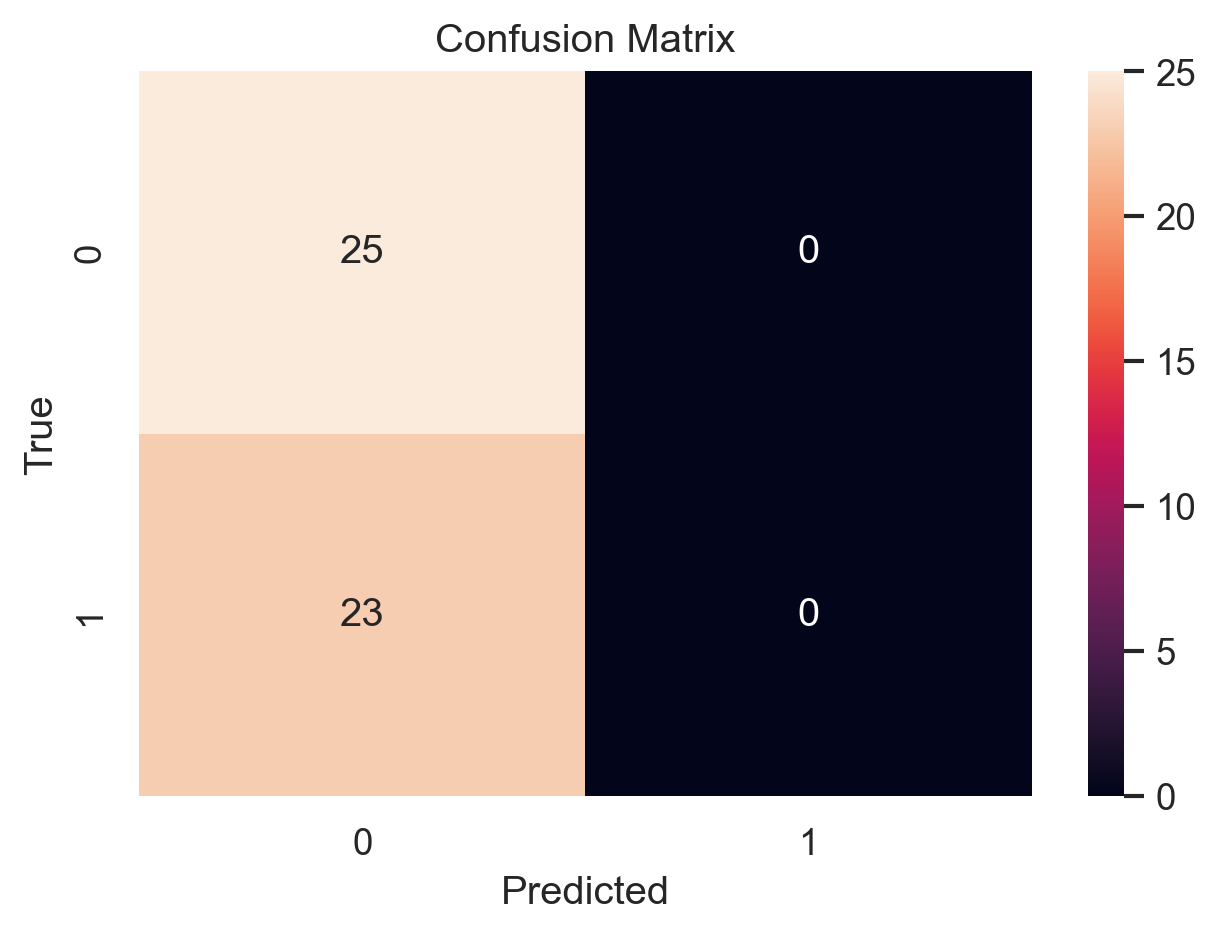


Case 2. Predicting all samples to be positive (class 2)

Balanced accuracy: 0.5
Recall: 1.0
Precision: 0.4791666666666667
AUC: 0.5
F1 score: 0.647887323943662
Fbeta score with beta = 0.1: 0.48165042504665145
Fbeta score with beta = 10: 0.9893526405451447


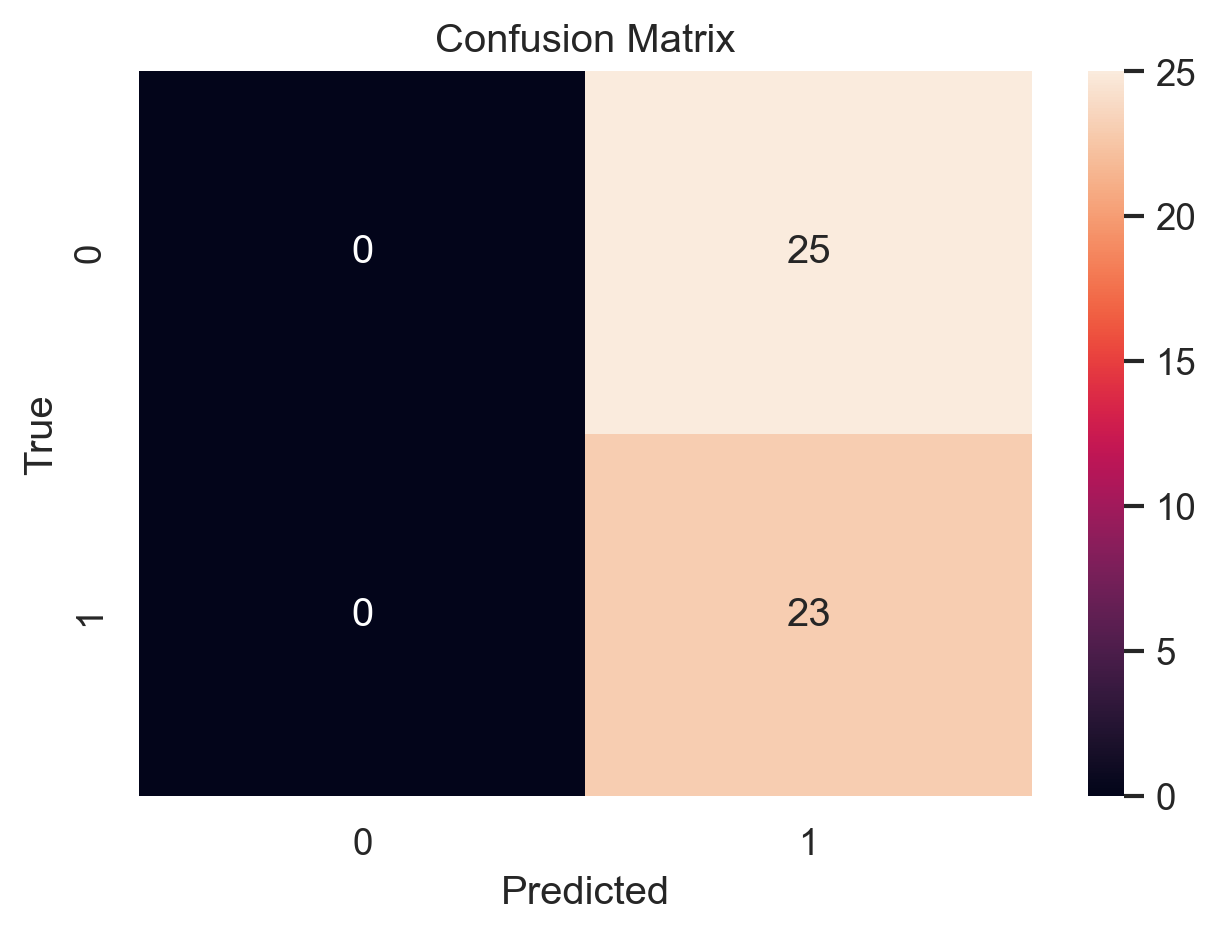


Case 3. Random prediction for each sample with equal probability for each class

Balanced accuracy: 0.5208695652173914
Recall: 0.5217391304347826
Precision: 0.5
AUC: 0.5208695652173914
F1 score: 0.5106382978723404
Fbeta score with beta = 0.1: 0.5002063557573256
Fbeta score with beta = 10: 0.5215146299483648


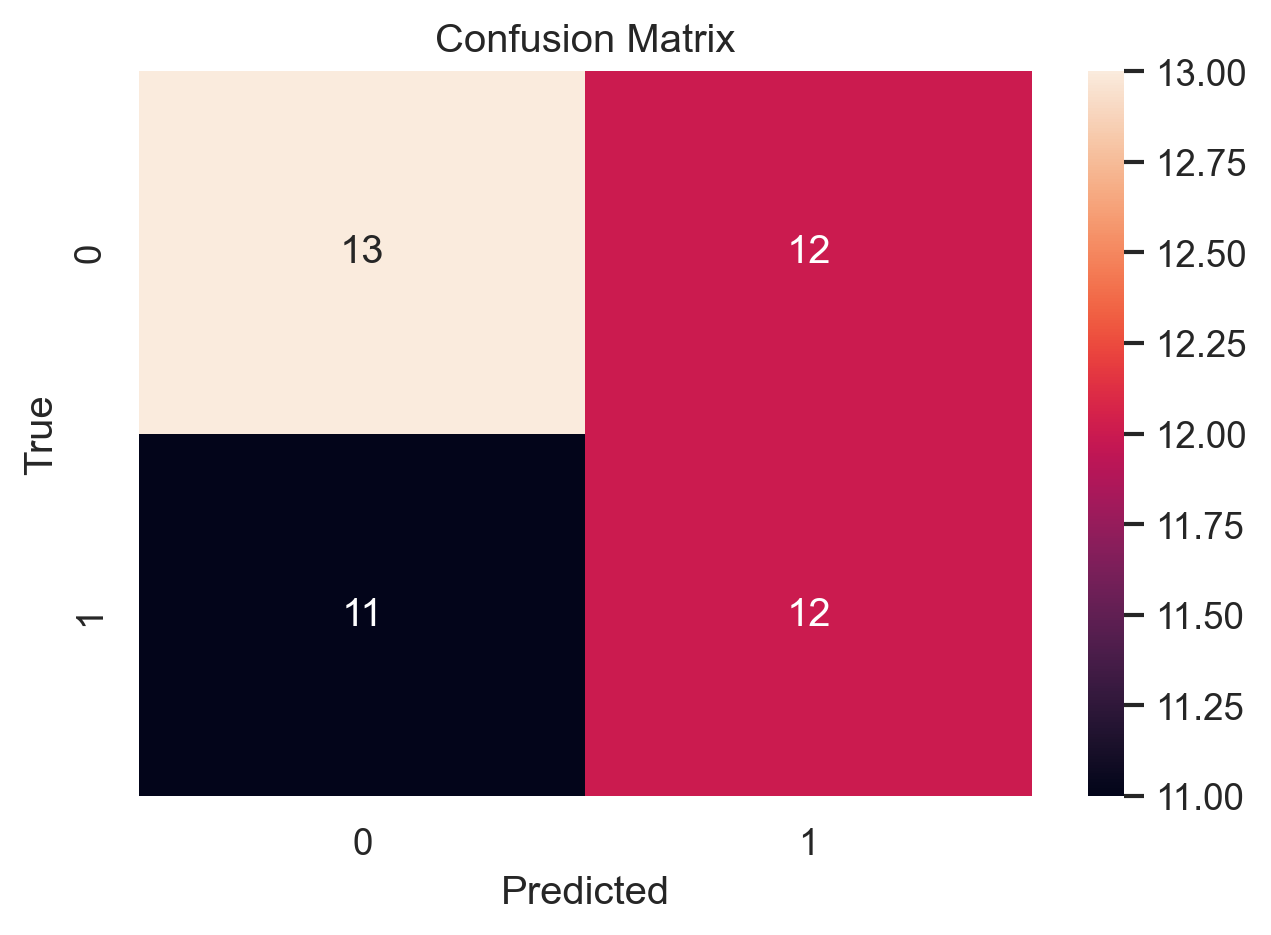

In [12]:
# 3 baseline cases
# 1. all samples to be negative (class 1)
# 2. all samples to be positive (class 2)
# 3. random prediction for each sample with equal probability for each class
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score, precision_score, \
    roc_auc_score, f1_score, roc_curve, precision_recall_curve, hinge_loss, auc

baseline_cases = [{
    'name' : '1. Predicting all samples to be negative (class 1)',
    'y_predict' : np.zeros(y_val.shape[0])
}, {
    'name' : '2. Predicting all samples to be positive (class 2)',
    'y_predict' : np.ones(y_val.shape[0])
}, {
    'name' : '3. Random prediction for each sample with equal probability for each class',
    'y_predict' : random_y_test
}]

def report_baseline_case(y_val, case):
    
    plt.rcParams['figure.dpi'] = 240
    plt.rcParams['savefig.dpi'] = 240
    
    y_predict = case['y_predict']
    name = case['name']
    
    # Print measures
    print(f'Case {name}\n')
    
    # Balanced accuracy
    print(f'Balanced accuracy: {balanced_accuracy_score(y_val, y_predict)}')
    
    # Recall, precision
    print(f'Recall: {recall_score(y_val, y_predict, zero_division=1)}')
    print(f'Precision: {precision_score(y_val, y_predict, zero_division=1)}')
        
    # AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=1)
    print(f'AUC: {auc(fpr, tpr)}')
    
    # F1 score
    print(f'F1 score: {f1_score(y_val, y_predict)}')
    
    # fbeta_score with beta=0.1
    print(f'Fbeta score with beta = 0.1: {f01_score(y_val, y_predict)}')
    
    # fbeta_score with beta=10
    print(f'Fbeta score with beta = 10: {f10_score(y_val, y_predict)}')

    # Calculate and display confusion matrix
    cmat = confusion_matrix(y_true=y_val, y_pred=y_predict)
    sns.heatmap(cmat,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print()
    
for index, case in enumerate(baseline_cases):
    report_baseline_case(y_val, case)

### 2.3 Choose a performance metric [0.5 marks]

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.  **Give a reason for your choice.**

#### Your answer here
Based on the requirements:
1. Have at least a 95% probability of detecting malignant cancer when it is present

=> recall or TPR >= 95%

2. Have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant)

=> FPR <= 10%


=> Recall (TPR) and FPR are importance in this scenario

Because AUC could reflect both TPR and FPR, AUC is chosen to be the performance metric to use for evaluating.

### 2.4 SGD baseline [1 mark]

For a stronger baseline, **train and evaluate** the Stochastic Gradient Descent classifier (as seen in workshop 5). For this baseline case use the default settings for all the hyperparameters.

AUC: 0.9565217391304348


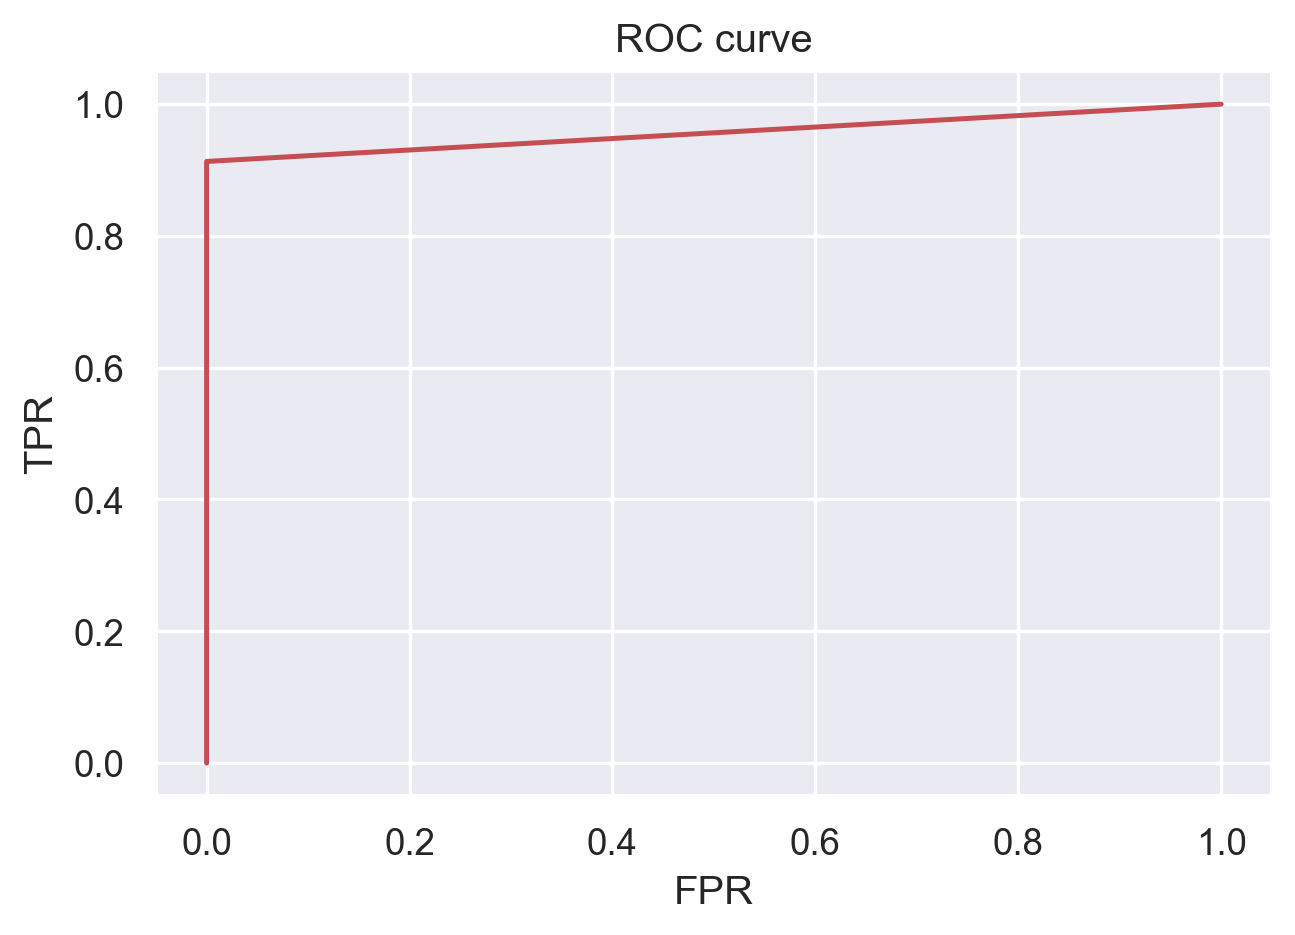

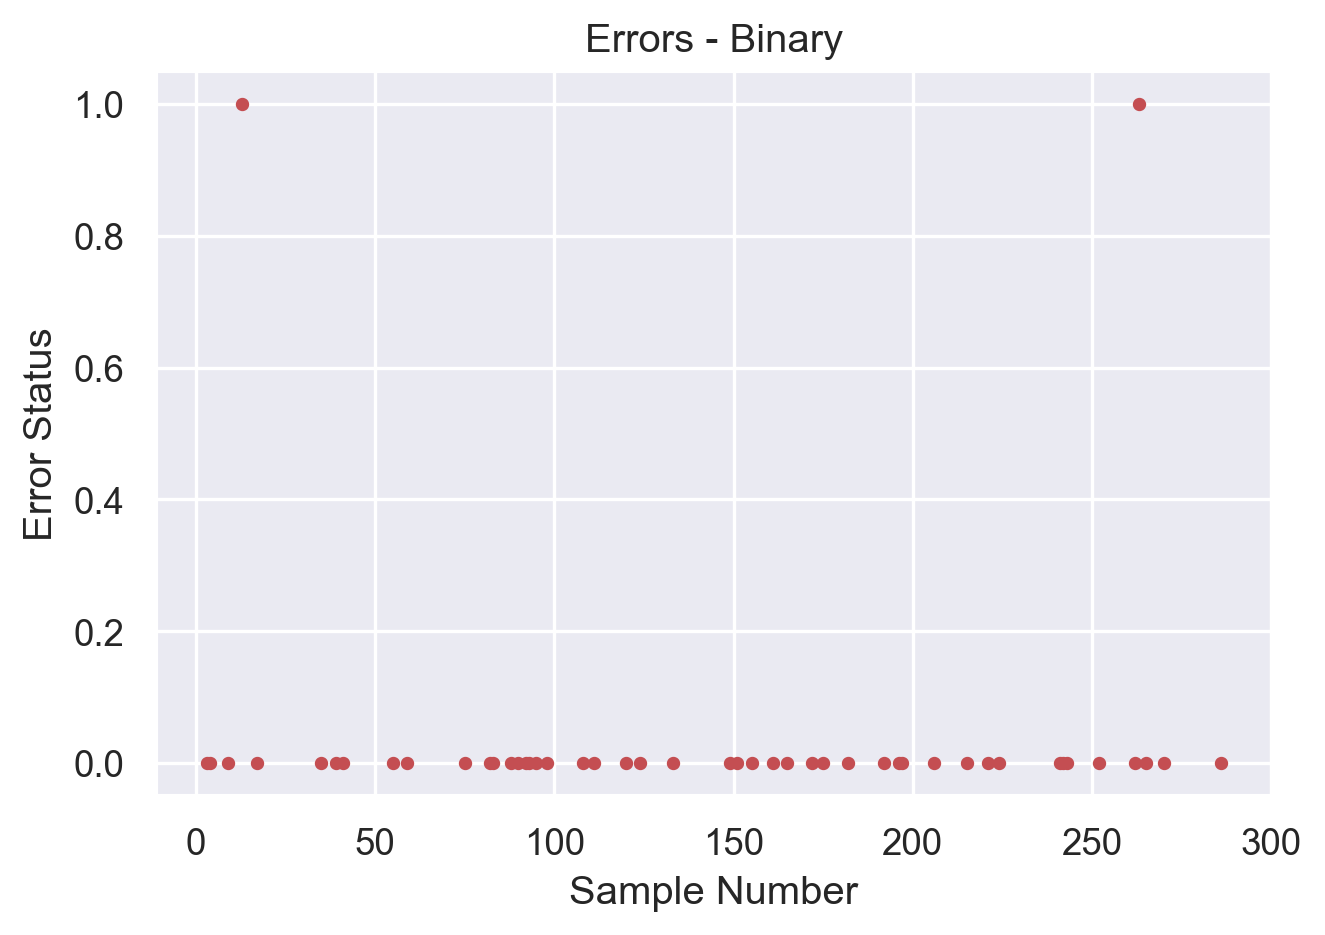

In [13]:
# Your code here
from sklearn.linear_model import SGDClassifier

sgd_pipeline = Pipeline([
    ('preprocess', preprocessing_pipeline), 
    ('sgd', SGDClassifier()) 
])

# Train
sgd_pipeline.fit(X_train,y_train)

# Predict
y_val_pred = sgd_pipeline.predict(X_val)

# Display Metric AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred, pos_label=1)
print(f'AUC: {auc(fpr, tpr)}')

# ROC curve
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,tpr,'r')
plt.title('ROC curve')
plt.show()

# Error binary
plt.plot(np.abs(y_val - y_val_pred),'r.')
plt.xlabel('Sample Number')
plt.ylabel('Error Status')
plt.title('Errors - Binary')
plt.show()

### 2.5 Confusion matrix [1 mark]

Calculate and display the normalized version of the confusion matrix.  From this **calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

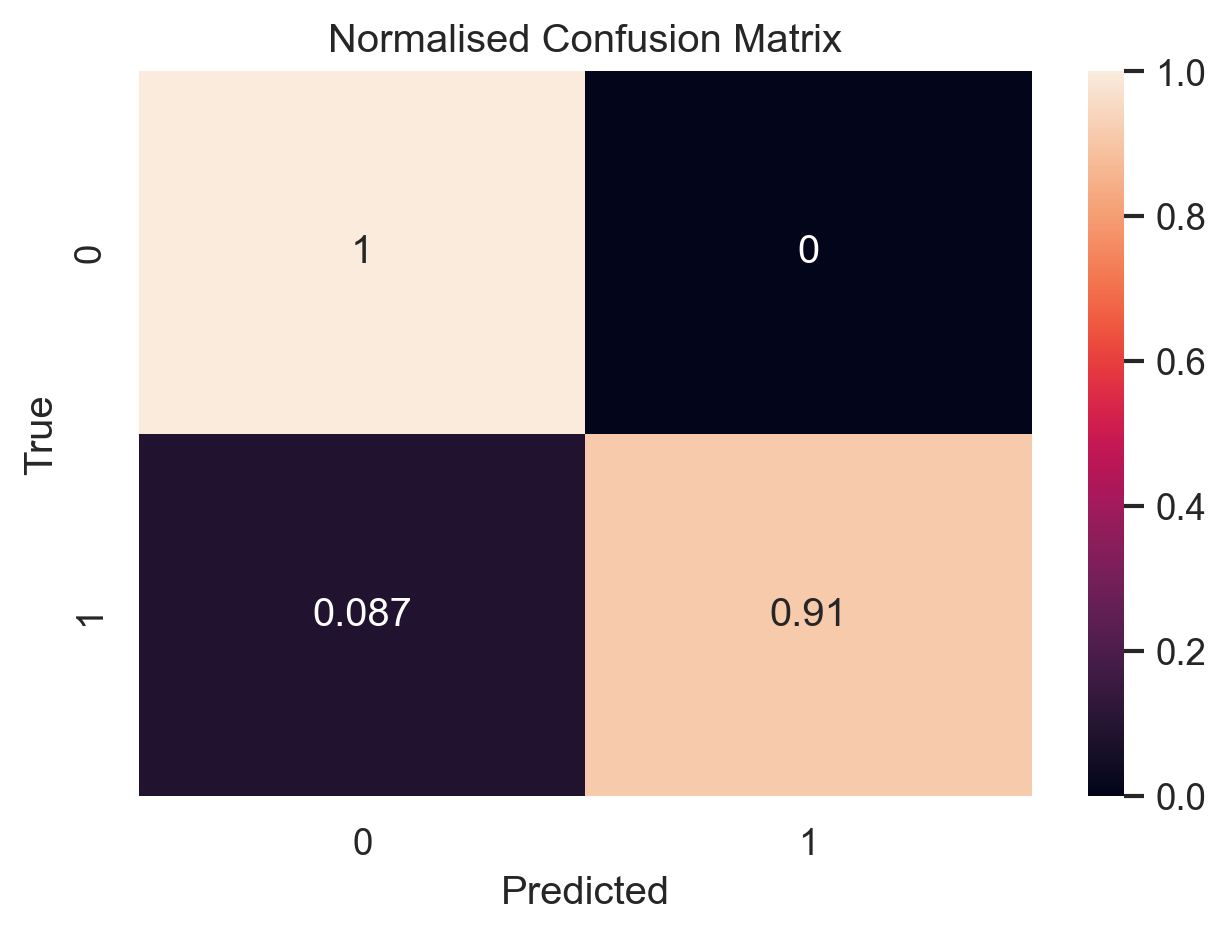

In [14]:
# Your code here
cmat = confusion_matrix(y_true=y_val, y_pred=y_val_pred, normalize='true')
sns.heatmap(cmat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

#### Your answer here

#### 1. calculate the probability that a sample from a person with a malignant tumour is given a result that they do not have cancer.

The probability that a sample from a person with a malignant tumour is given a result that they do not have cancer is 8.7%

#### 2. Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?
It is related to criteria 1: Have at least a 95% probability of detecting malignant cancer when it is present

It is not satisfying because the probability of detecting malignant cancer when it is present is only 91%

### 2.6 Main classifier [11 marks]

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier
 
Follow best practice as much as possible here. You must make all the choices and decisions yourself, and strike a balance between computation time and performance.

You can use any of the sci-kit learn functions in sklearn.model_selection.cross* and anything used in workshops 3, 4, 5 and 6. Other hyper-parameter optimisation functions apart from these cannot be used (even if they are good and can be part of best practice in other situations - for this assignment everyone should assume they only have very limited computation resources and limit themselves to these functions).

**Display the performance of the different classifiers and the optimised hyperparameters.**

**Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.**

In [15]:
# Your code here
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier

# 1. KNN (K-Nearest Neighbour) classifier
knn_pl = Pipeline([ 
    ('preprocess',preprocessing_pipeline), 
    ('knn',KNeighborsClassifier())
])

knn_params = dict(
    knn__n_neighbors=[3,5,10,20,30,50],
    knn__weights=['uniform','distance']
)

# 2. Decision tree classifier
dt_pl = Pipeline([ 
    ('preprocess',preprocessing_pipeline), 
    ('dt',DecisionTreeClassifier())
])

dt_params = dict(
    dt__max_depth=range(1,20),
    dt__min_samples_leaf=range(1,20)
)

# 3. Support vector machine classifier
svc_pl = Pipeline([ 
    ('preprocess',preprocessing_pipeline), 
    ('svc',SVC())
])

svc_params = dict(
    svc__kernel=['linear','rbf','poly']
)

# 4. SGD classifier
sgd_pl = Pipeline([ 
    ('preprocess',preprocessing_pipeline),
    ('sgd',SGDClassifier()) 
])

sgd_params = dict(
    sgd__alpha=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    sgd__penalty=['l2','l1','elasticnet'],
    sgd__learning_rate=['constant','optimal'],
    sgd__eta0=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
)

# List models
dict_models = dict()
dict_models["KNN (K-Nearest Neighbour) classifier"] = (knn_pl, knn_params)
dict_models["Decision tree classifier"] = (dt_pl, dt_params)
dict_models["Support vector machine classifier"] = (svc_pl, svc_params)
dict_models["SGD classifier"] = (sgd_pl, sgd_params)

# Scorer
scorer = 'roc_auc'

# List score of models
dict_scores = dict()

In [16]:
def report_model(pl, params, model_name, y_true):
    cv = GridSearchCV(
        pl,
        params,
        cv=5,
        n_jobs=-1,
        scoring=scorer,
        return_train_score=True)

    cv.fit(X_train,y_train)

    print(model_name)

    print(f'Best params for {model_name} : {cv.best_params_}')

    # Using best estimator to predict
    cv.best_estimator_.fit(X_train,y_train)
    y_pred = cv.best_estimator_.predict(X_val)
    
    # AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auc_score = auc(fpr, tpr)
    print(f'AUC: {auc_score}')
    
    # ROC curve
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot(fpr,tpr,'r')
    plt.title('ROC curve')

    plt.show()

    # Calculate and display confusion matrix
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    sns.heatmap(cmat,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Add score to dictionary
    dict_scores[model_name] = (auc_score, cv.best_estimator_, cv.best_params_)
    
    print()
    
    return auc_score

KNN (K-Nearest Neighbour) classifier
Best params for KNN (K-Nearest Neighbour) classifier : {'knn__n_neighbors': 20, 'knn__weights': 'distance'}
AUC: 0.9365217391304348


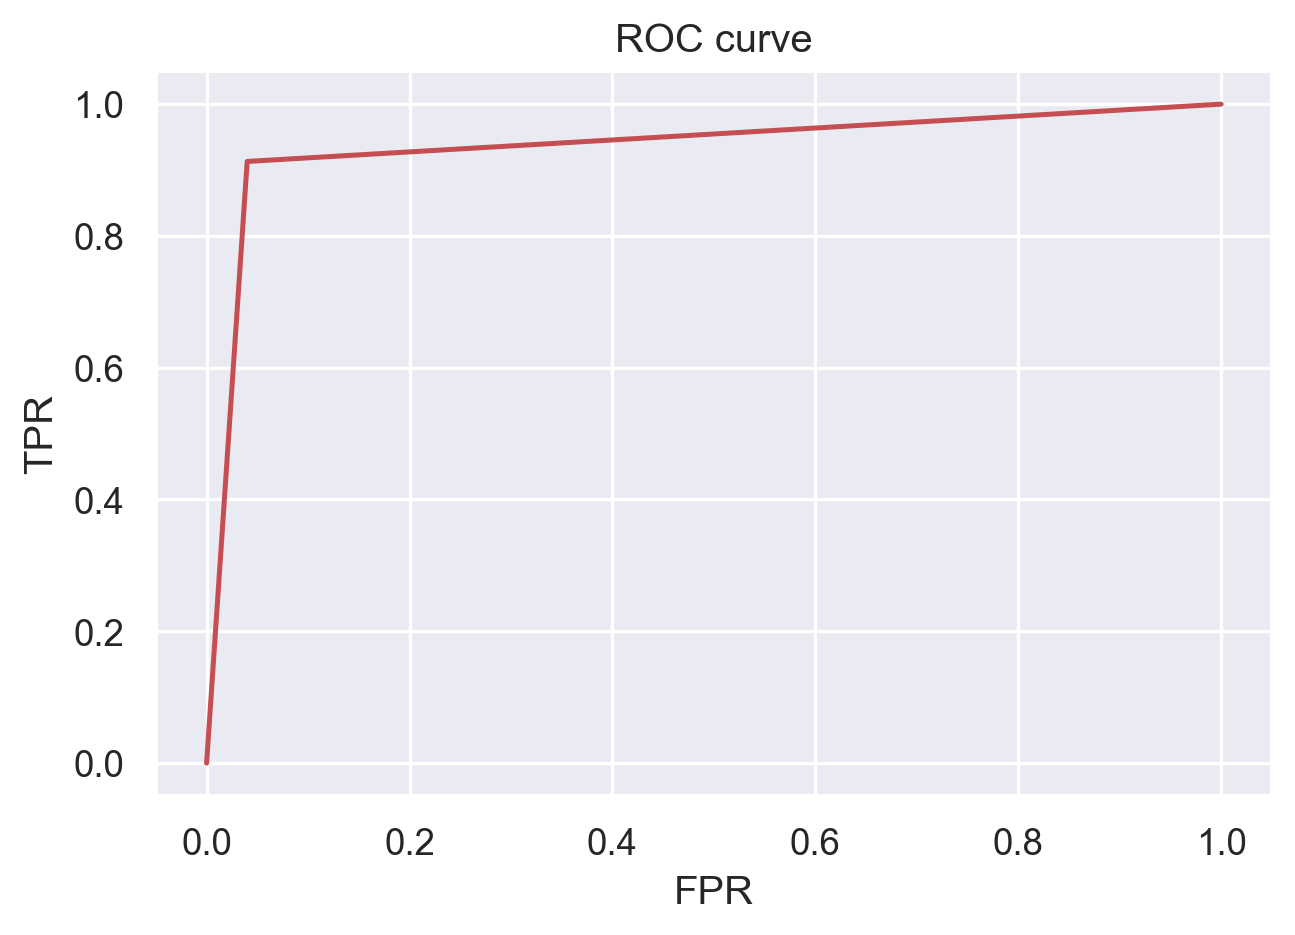

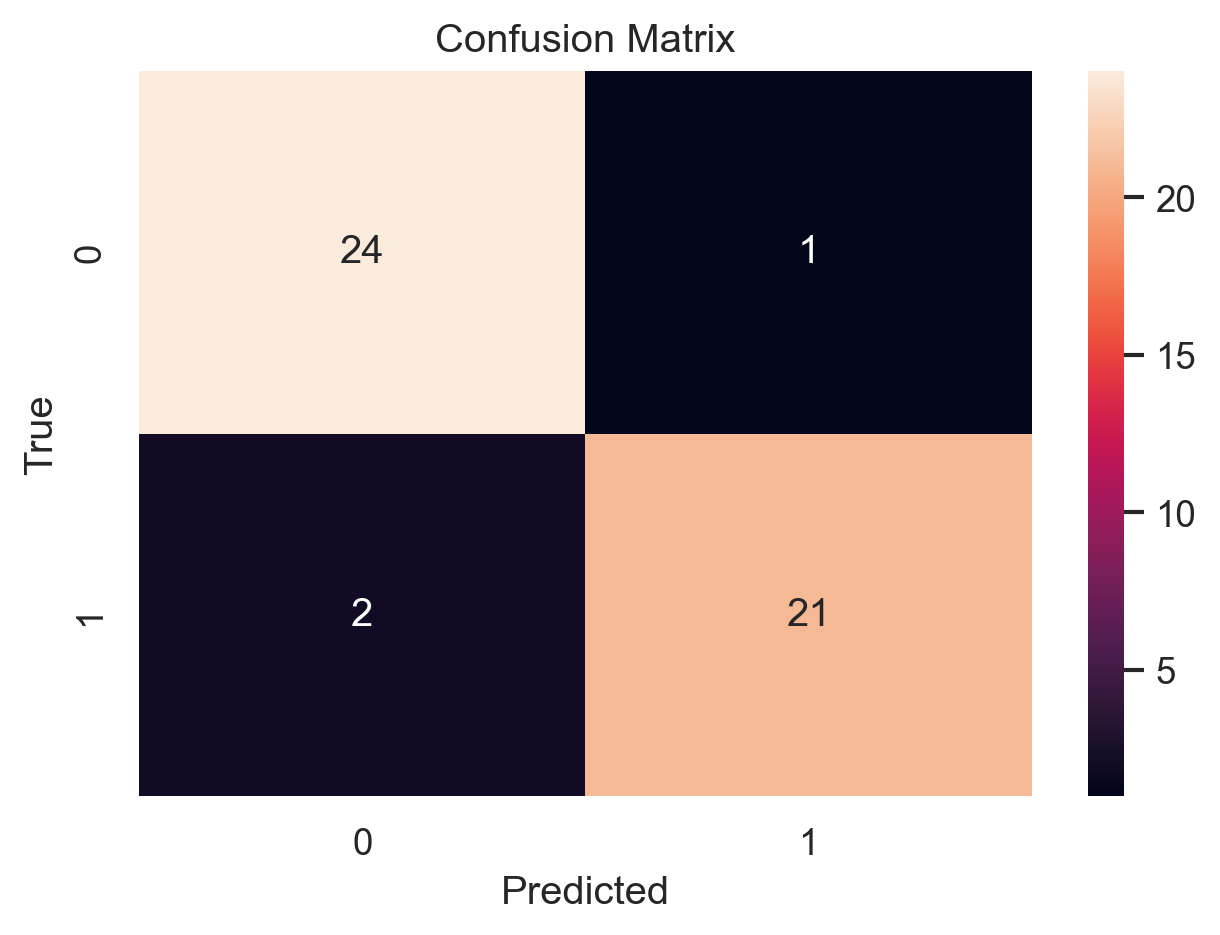


Decision tree classifier
Best params for Decision tree classifier : {'dt__max_depth': 5, 'dt__min_samples_leaf': 7}
AUC: 0.8930434782608696


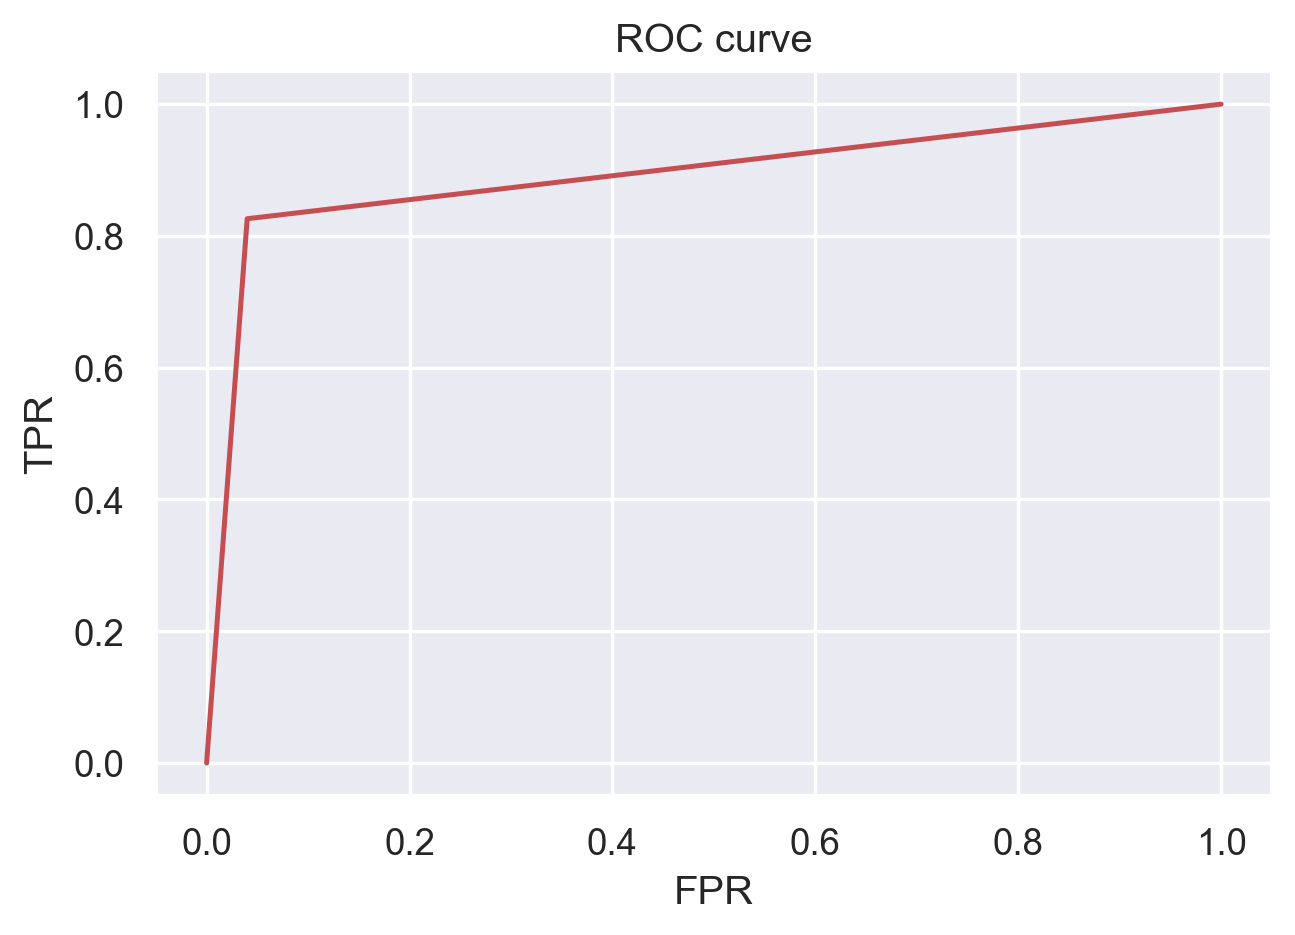

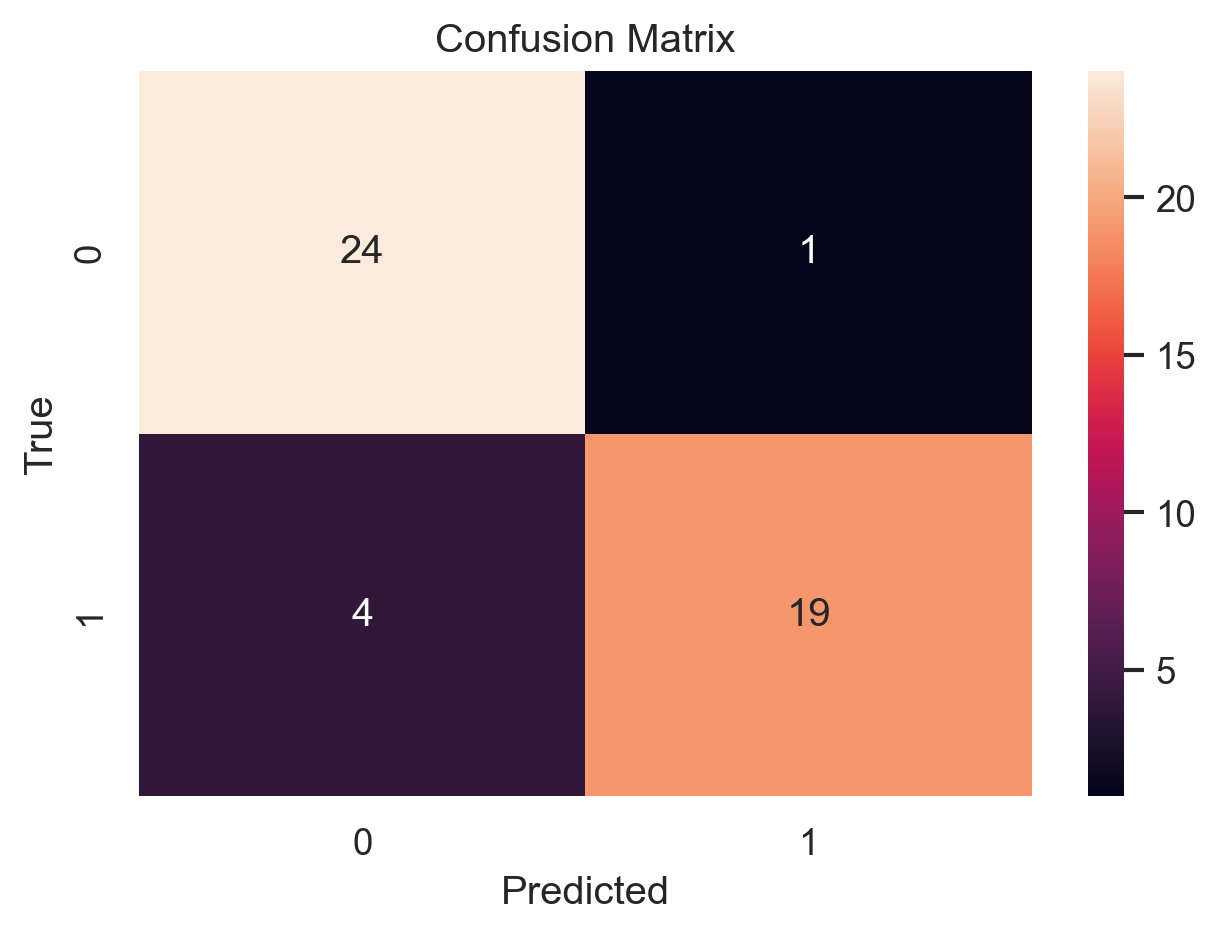


Support vector machine classifier
Best params for Support vector machine classifier : {'svc__kernel': 'rbf'}
AUC: 0.9365217391304348


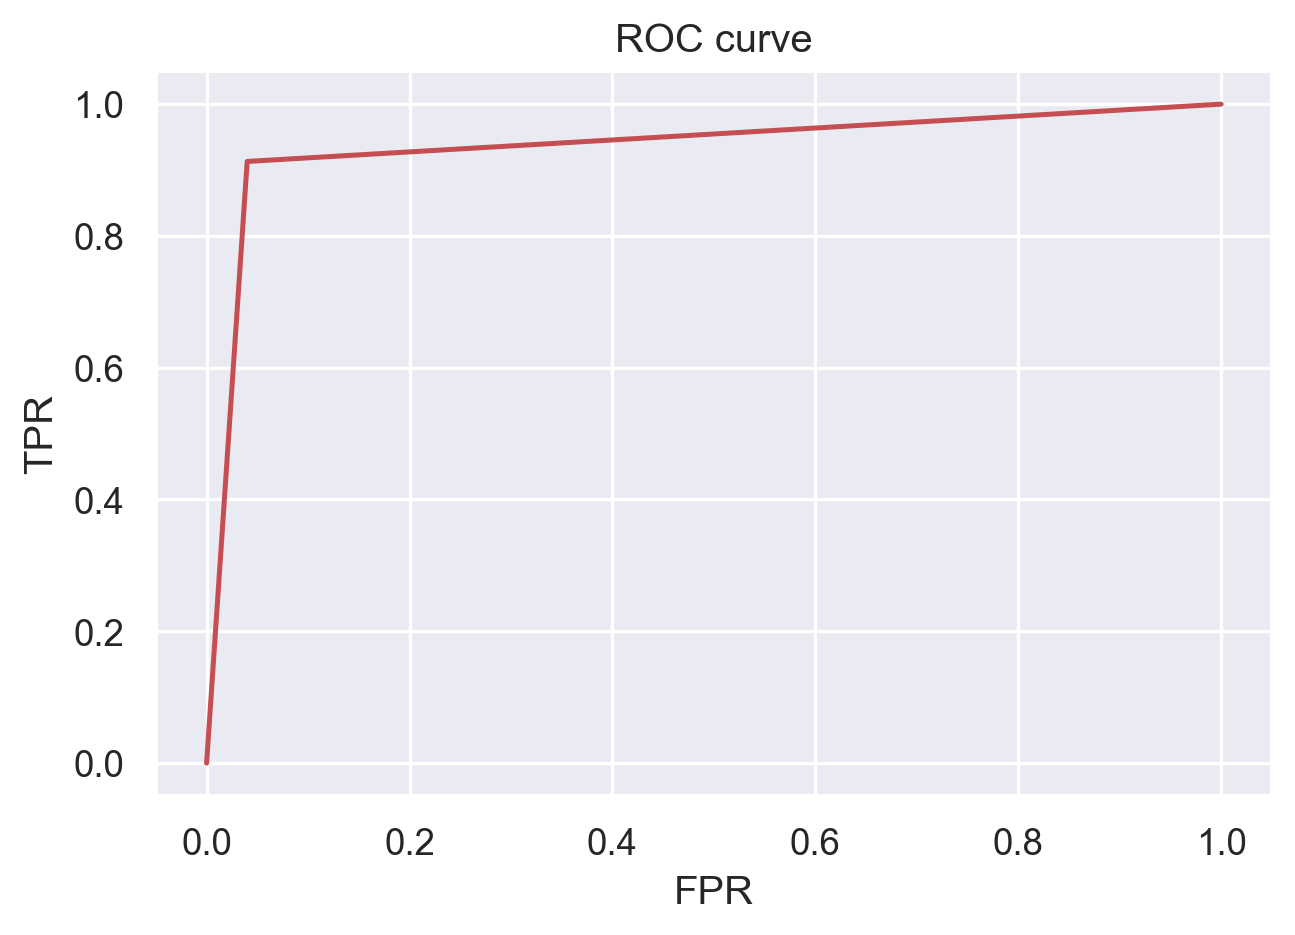

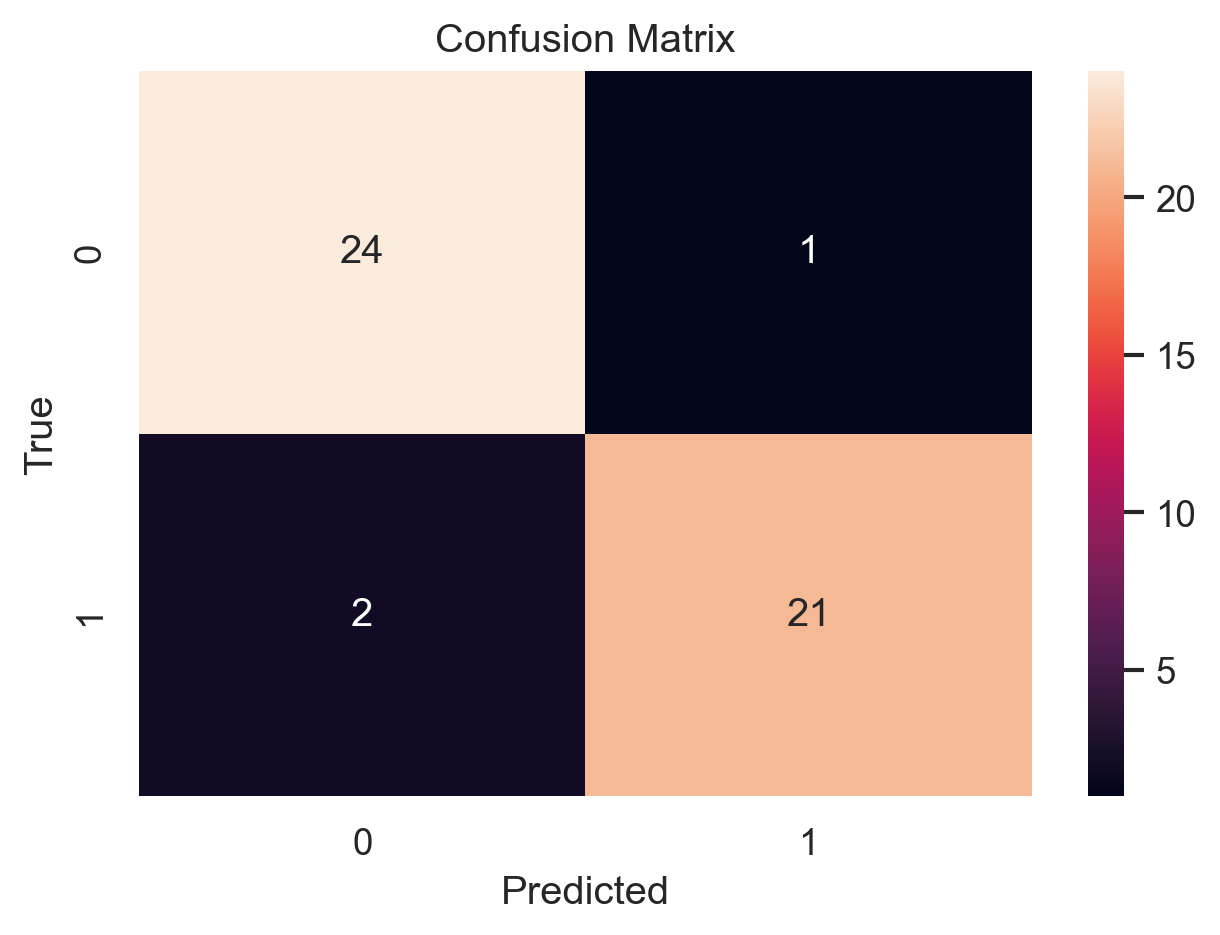


SGD classifier
Best params for SGD classifier : {'sgd__alpha': 0.1, 'sgd__eta0': 0.0001, 'sgd__learning_rate': 'optimal', 'sgd__penalty': 'l2'}
AUC: 0.9565217391304348


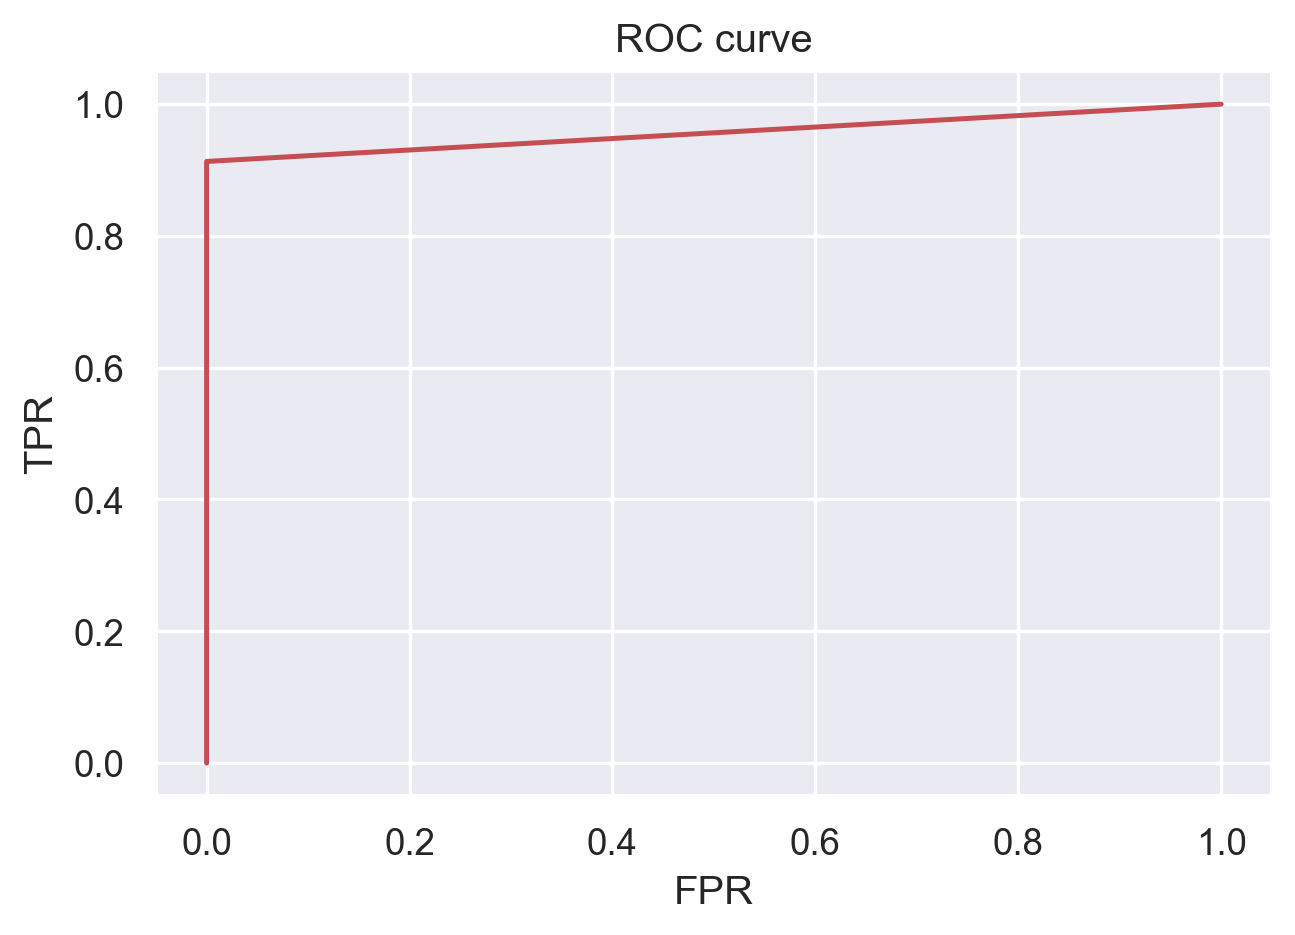

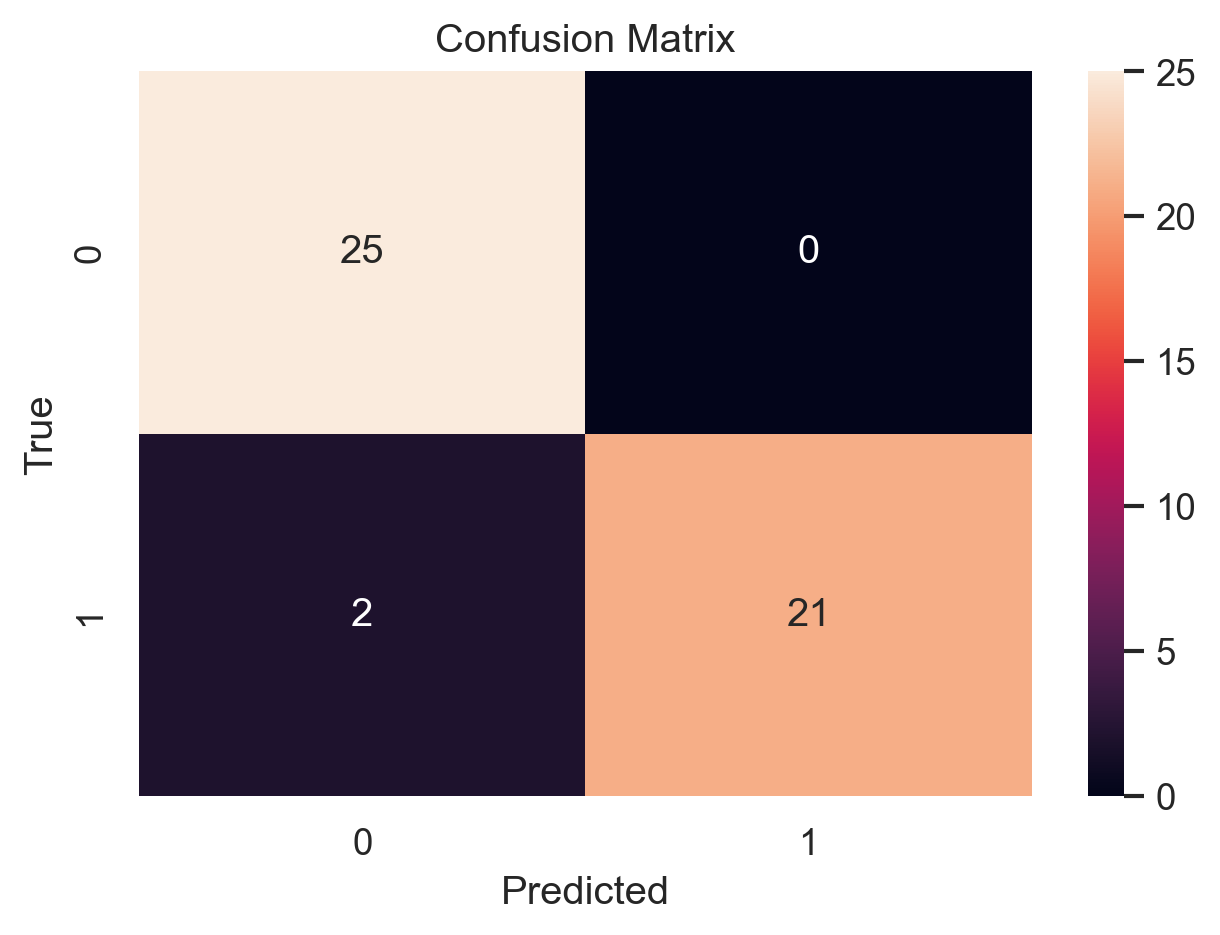

In [17]:
for key, value in dict_models.items():
    pl = value[0]
    params = value[1]
    report_model(pl, params, key, y_val)

In [18]:
for key, value in dict_scores.items():
    print(f'{key}')
    print(f'\tAUC = {value[0]}')

KNN (K-Nearest Neighbour) classifier
	AUC = 0.9365217391304348
Decision tree classifier
	AUC = 0.8930434782608696
Support vector machine classifier
	AUC = 0.9365217391304348
SGD classifier
	AUC = 0.9565217391304348


In [19]:
# Your answer here

print(f"""
List of the best 3 classifiers based on evaluation on the validation set:
1. SGD classifier with the highest AUC nearly {100*round(dict_scores['SGD classifier'][0], 2)}%
2. KNN classifier and Support vector machine classifier perform equivalent with AUC around {100*round(dict_scores['KNN (K-Nearest Neighbour) classifier'][0], 2)}%

These three classifier performs equally great on this dataset, but the size of validation set is too small. If the validation dataset is larger, performance measurement will be more accuracy.
""")


List of the best 3 classifiers based on evaluation on the validation set:
1. SGD classifier with the highest AUC nearly 96.0%
2. KNN classifier and Support vector machine classifier perform equivalent with AUC around 94.0%

These three classifier performs equally great on this dataset, but the size of validation set is too small. If the validation dataset is larger, performance measurement will be more accuracy.



### 2.7 Model selection [1 mark]

**Choose the best classifier** (as seen in workshops 3 to 6) and give details of your hyperparameter settings. **Explain the reason for your choice.**

In [20]:
# Your answer here
# index 0: auc score
# index 1: cv.best_estimator_
# index 2: cv.best_params_
sgd = dict_scores['SGD classifier']
print(f'hyperparameter settings : {sgd[2]}')
model = sgd[1]
print(model)

hyperparameter settings : {'sgd__alpha': 0.1, 'sgd__eta0': 0.0001, 'sgd__learning_rate': 'optimal', 'sgd__penalty': 'l2'}
Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('sgd', SGDClassifier(alpha=0.1, eta0=0.0001))])


Your answer here

The **SGD classifier** has been selected as the best model in this stage because from the above classifier comparison figure, the SGD classifier has the highest AUC score on the validation set

### 2.8 Final performance [1.5 marks]

**Calculate and display an unbiased performance measure that you can present to the client.**

**Is your chosen classifier underfitting or overfitting?**

**Does your chosen classifier meet the client's performance criteria?**

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('sgd', SGDClassifier(alpha=0.1, eta0=0.0001))])
AUC: 0.9666295884315907


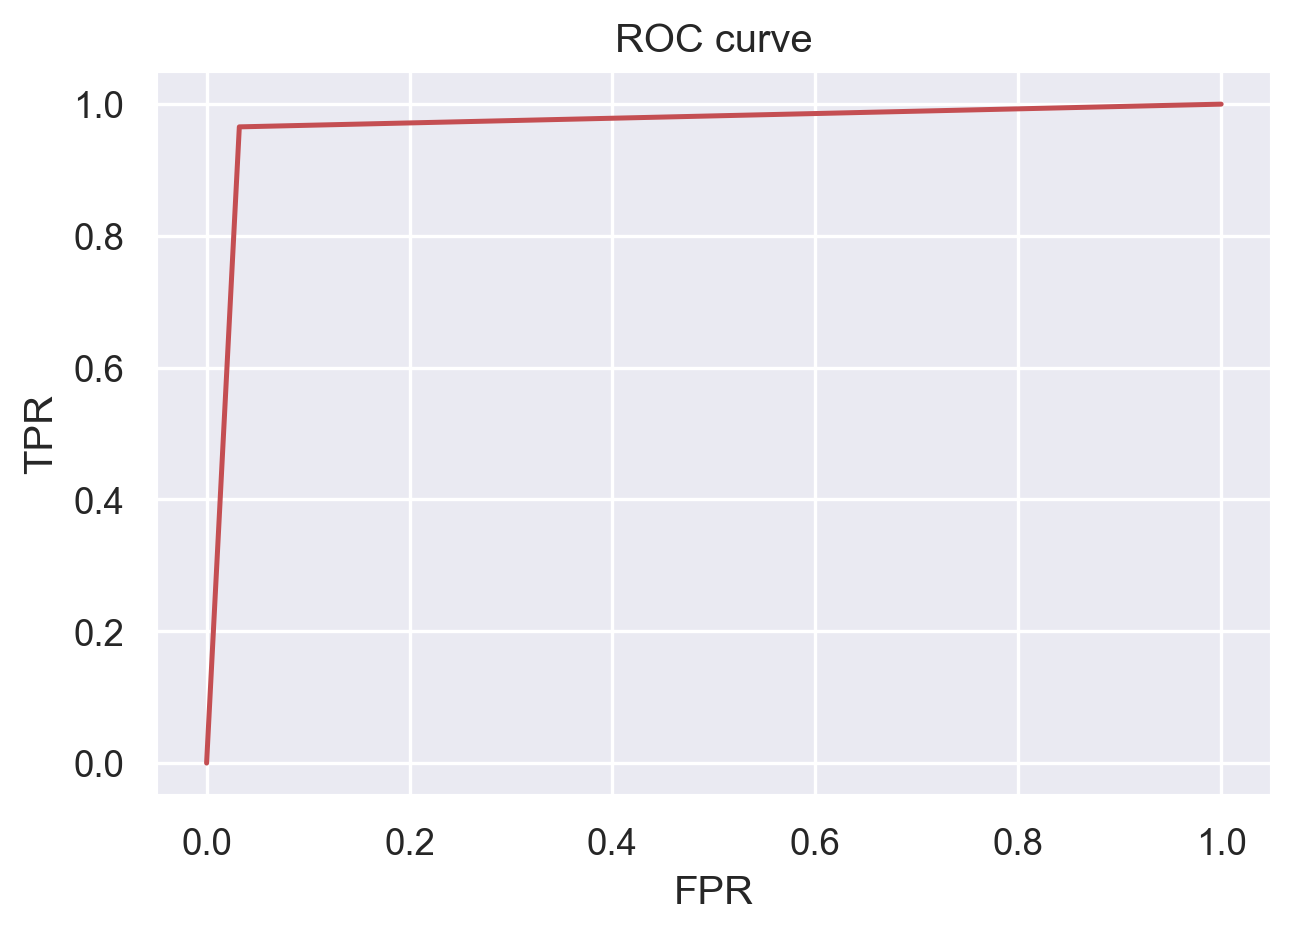

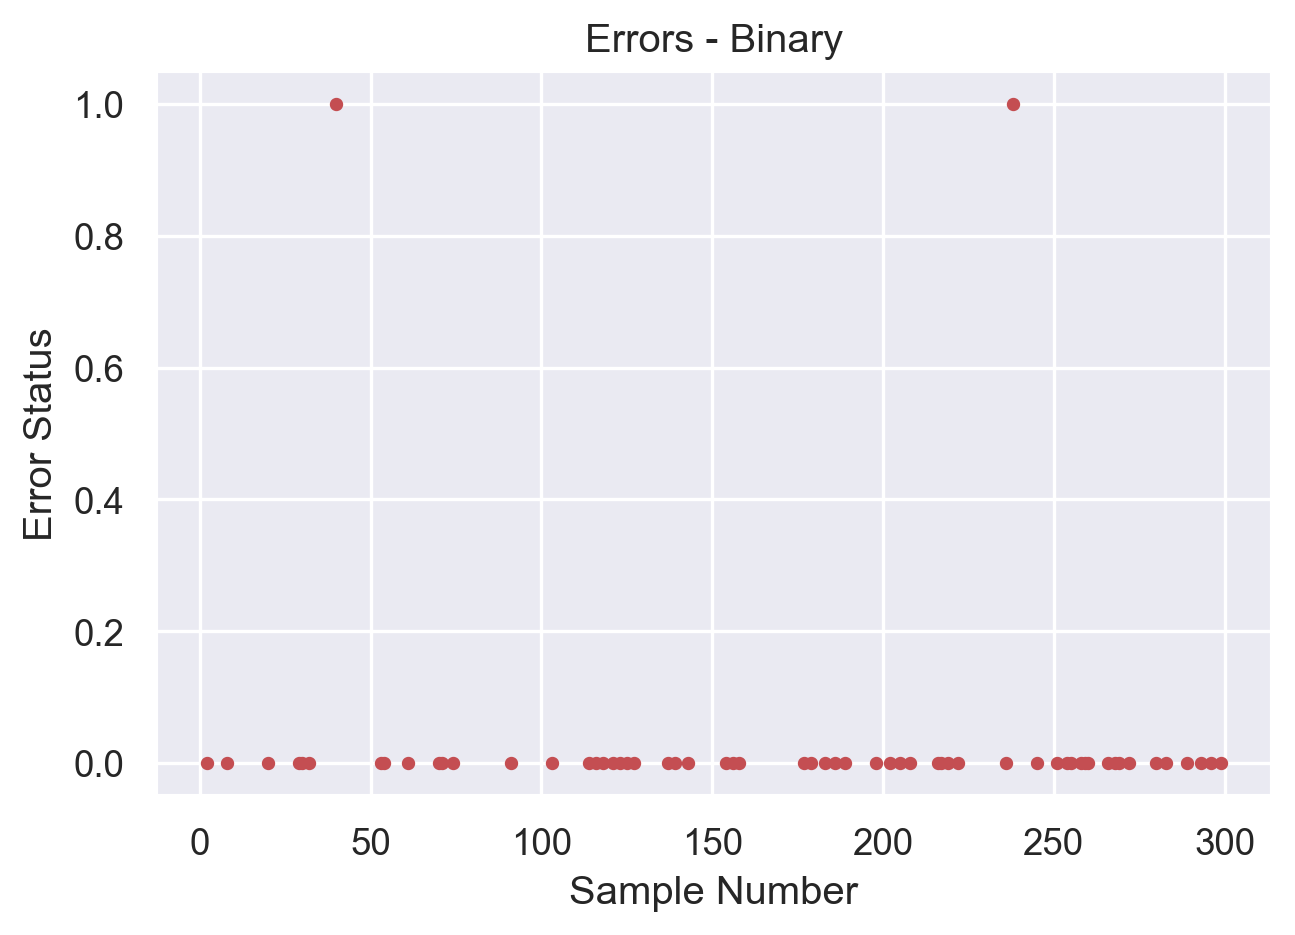

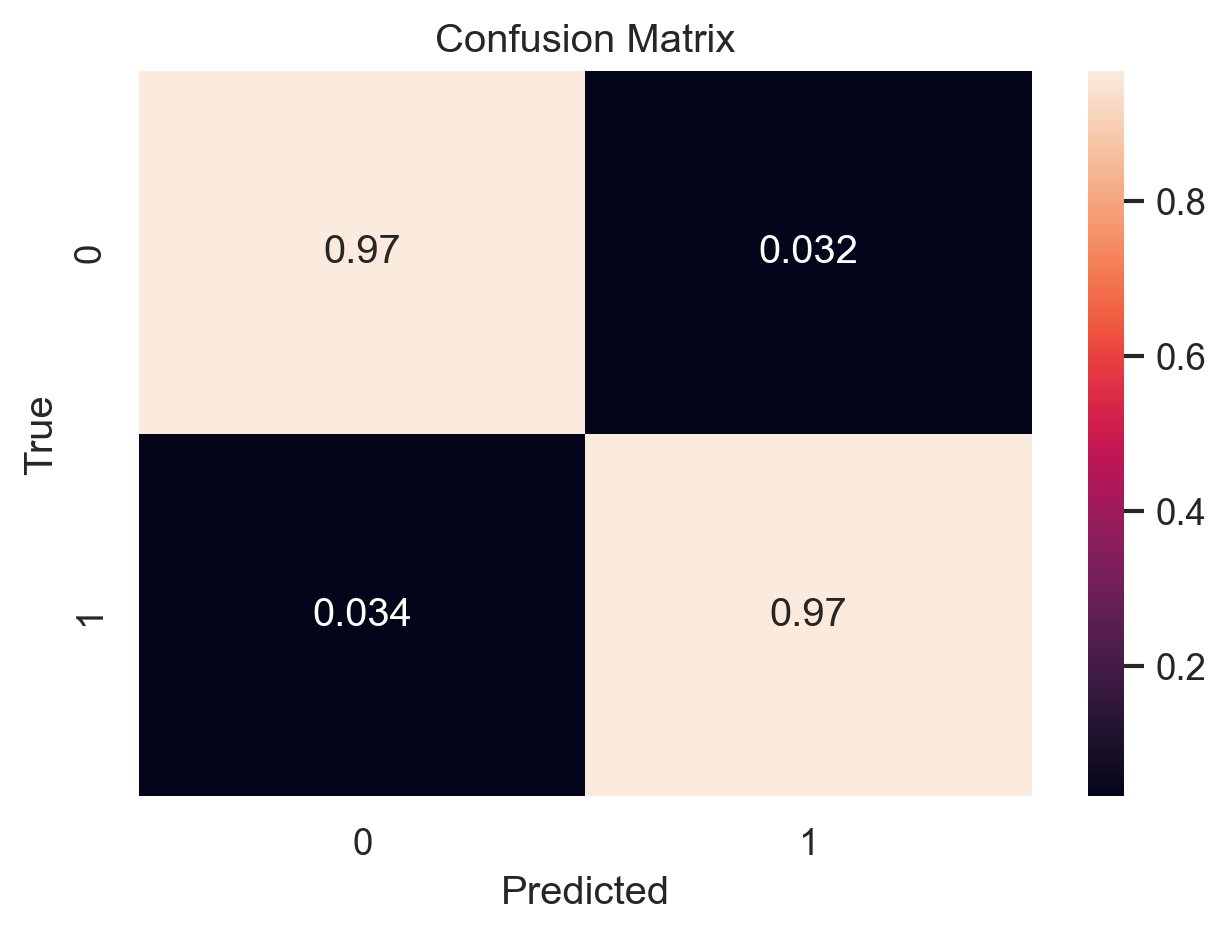

In [21]:
# Your code here

print(model)

# Get the whole training set
X_train_whole = bigtrain_set.drop("label",axis=1)
y_train_whole = bigtrain_set["label"].copy()

# Train model
model.fit(X_train_whole, y_train_whole)

# Predict on test set
y_test_pred = model.predict(X_test)
        
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label=1)
print(f'AUC: {auc(fpr, tpr)}')

# ROC curve
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,tpr,'r')
plt.title('ROC curve')
plt.show()

# Error binary
plt.plot(np.abs(y_test - y_test_pred),'r.')
plt.xlabel('Sample Number')
plt.ylabel('Error Status')
plt.title('Errors - Binary')
plt.show()

# Calculate and display confusion matrix
cmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize='true')
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Your answers here

Requirements:

1. Have at least a 95% probability of detecting malignant cancer when it is present (recall or TPR >= 95%)

2. Have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant) (FPR <= 10%)

According to the evaluation metrics for test set, the model produces 97% on recall and AUC and lower than 1% on FPR. Therefore, we can say that this model is **neither** underfitting nor overfitting.

=> This model meet the client's performance criteria.




## 3. Decision Boundaries (15% = 4.5 marks)

### 3.1 Rank features [1 mark]

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is (mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1))), where x1 and x2 are the datasets corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [22]:
# Your code here
# Dataset contains only positive label
dataset_pos = dataset.where(dataset['label'] == 1).dropna()
dataset_pos.drop('label',axis=1,inplace=True)

# Dataset contains only negative label
dataset_neg = dataset.where(dataset['label'] == 0).dropna()
dataset_neg.drop('label',axis=1,inplace=True)

# Check dataset shape
dataset_pos.shape, dataset_neg.shape

((146, 30), (154, 30))

In [23]:
def calculate_t_score(x1, x2):
    return (x1.mean() - x2.mean())/(0.5*(x1.std() + x2.std()))

list_t_score = []
# Calculate t score for all features
for feature in features:
    t_score = calculate_t_score(dataset_pos[feature], dataset_neg[feature])
    list_t_score.append((feature, t_score))
    
list_t_score.sort(key=lambda tup: tup[1], reverse=True)

In [24]:
print('The best 4 features according to t_score')
for item in list_t_score[:4]:
    print(f'{item[0]}: t_score = {item[1]}')

The best 4 features according to t_score
worst concave points: t_score = 2.4871607332953354
worst perimeter: t_score = 2.473073212650544
worst radius: t_score = 2.4108393809617583
mean concave points: t_score = 2.229435693128837


### 3.2 Visualise decision boundaries [2.5 marks]

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help (taken from workshop 6).

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following: 0.5*(mean(x1) + mean(x2)), where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [25]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min - 50*hx, x_max + 50*hx, hx), np.arange(y_min - 50*hy, y_max + 50*hy, hy))
    return xx, yy

In [26]:
def plot_contours(clf, xx, yy, xmean, n1, n2, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of mean values (to populate constant features with)
    n1, n2: index numbers of features that change (for xx and yy)
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('sgd', SGDClassifier(alpha=0.1, eta0=0.0001))])


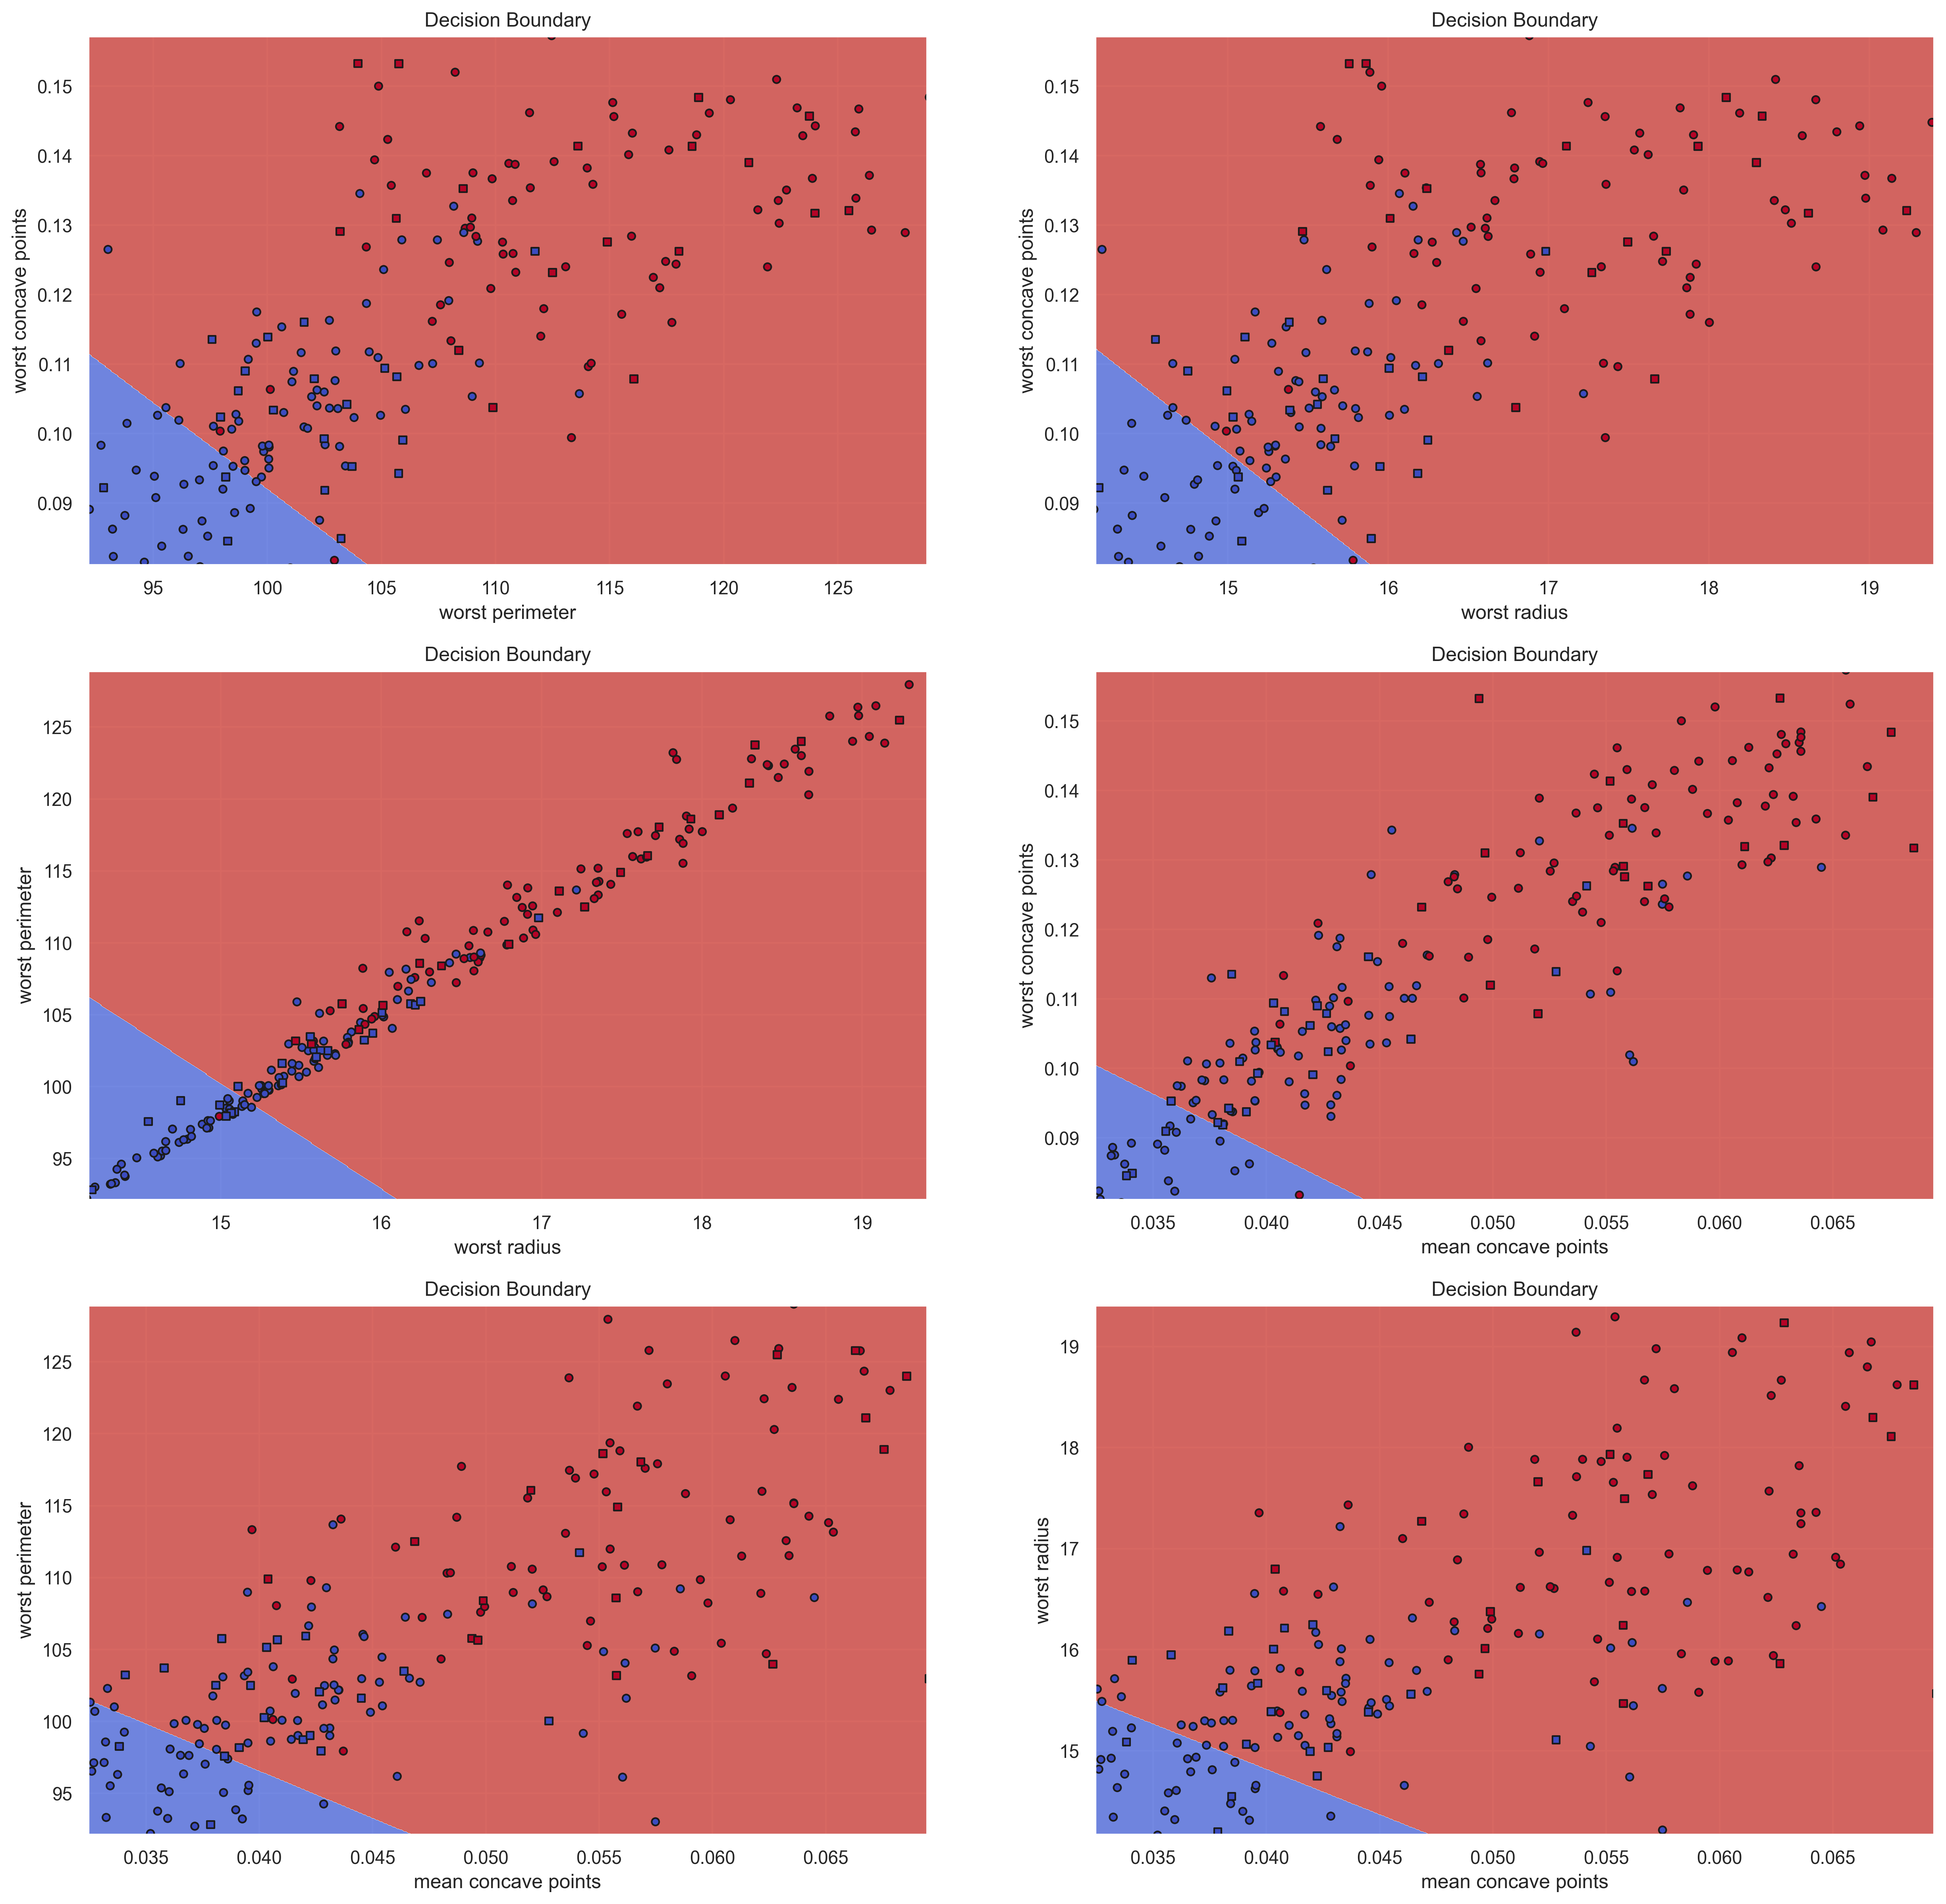

In [27]:
# Your code here
def calculate_x_mean(x1,x2):
    return 0.5* (np.mean(x1,axis=0) + np.mean(x2,axis=0))

# Get the best 4 feature names
feature_names = [item[0] for item in list_t_score[:4]]

# Setting figsize
fig=plt.figure(figsize=(20,20), dpi=300)

# Train model sgd with the whole training dataset
sgd = dict_scores['SGD classifier']
best_model = sgd[1]
print(best_model)
best_model.fit(X_train_whole.values, y_train_whole.values)

X_train_local = X_train.copy().values
X_valid_local = X_val.copy().values

# Calculate x mean by using the following: 0.5*(mean(x1) + mean(x2))
X_mean = calculate_x_mean(dataset_pos.values, dataset_neg.values)

# Visualize the decision boundary between 2 features
def decision_boundary(feature_one, feature_two):

    n0 = X_train.columns.get_loc(feature_one)
    n1 = X_train.columns.get_loc(feature_two)

    x10, x90 = np.percentile(X_train_local[:,n0],[10,90])
    y10, y90 = np.percentile(X_train_local[:,n1],[10,90])
    xx, yy = make_meshgrid(np.array([x10, x90]), np.array([y10, y90]), 500)
    
    # Plot
    plot_contours(
        best_model, 
        xx, 
        yy, 
        X_mean, 
        n0, 
        n1, 
        cmap=plt.cm.coolwarm, 
        alpha=0.8
    )

    plt.scatter(
        X_train_local[:,n0], 
        X_train_local[:,n1], 
        c=y_train.values, 
        cmap=plt.cm.coolwarm, 
        s=20, 
        edgecolors="k"
    )

    plt.scatter(
        X_valid_local[:,n0], 
        X_valid_local[:,n1], 
        c=y_val.values, 
        cmap=plt.cm.coolwarm, 
        s=20, 
        edgecolors="k", 
        marker='s'
    )

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(f"Feature {feature_one}")
    plt.ylabel(f"Feature {feature_two}")
    plt.title("Decision Boundary")


# Visualize the decision boundary between each pair of features
count = 0
for i in range(4):
    for j in range(4):
        if (i > j):
            # Setting figure
            ax=fig.add_subplot(3,2,count+1)
            
            # Show decision boundary for each pair of features
            decision_boundary(feature_names[i],feature_names[j])
            
            # labels of figure
            plt.xlabel(feature_names[i])
            plt.ylabel(feature_names[j])
        else:
            count = count-1
        count = count+1
plt.show()

### 3.3 Interpretation [1 mark]

From the decision boundaries displayed above, **would you expect the method to extrapolate well or not**?  Give reasons for your answer.

#### Your answer here

A decision boundary is the region of a problem space in which the output label of a classifier is ambiguous. If the decision surface is a hyperplane, then the classification issue is linear, and the classes are linearly separable. Decision boundaries are not always clear-cut.

The decision boundary divides the forecast into blue and red regions, while the ground truth is represented by a dot on the graphic. The findings indicate that the decision boundary of my prefered model, the SGD classifier, extrapolates well with reasonable errors for these problems.

## 4. Second Round (15% = 4.5 marks)

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**



### 4.1 New estimate [3.5 marks]

**Calculate an unbiased performance estimate** for this new problem, as requested by the client.

In [28]:
# Your code here
dataset_without_worst = dataset.copy()
dataset_without_worst = dataset_without_worst[
    dataset_without_worst.columns.drop(list(dataset_without_worst.filter(regex='worst')))
]
dataset_without_worst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    int64  
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

In [29]:
# Split dataset
bigtrain_set_without_worst, test_set_without_worst = train_test_split(dataset_without_worst, test_size=0.2, random_state=42, stratify=dataset_without_worst['label'])
train_set_without_worst, val_set_without_worst = train_test_split(bigtrain_set_without_worst, test_size=0.2, random_state=42, stratify=bigtrain_set_without_worst['label'])

In [30]:
# Verify the size and label distribution in each dataset.
X_train_without_worst = train_set_without_worst.drop("label",axis=1)
y_train_without_worst = train_set_without_worst["label"].copy()
X_test_without_worst = test_set_without_worst.drop("label",axis=1)
y_test_without_worst = test_set_without_worst["label"].copy()
X_val_without_worst = val_set_without_worst.drop("label",axis=1)
y_val_without_worst = val_set_without_worst["label"].copy()

print(f'Shape of the whole dataset: {dataset_without_worst.shape}')
print()

print("Verify the size in each dataset")

print(f'\t1. Shape of the training dataset: {train_set_without_worst.shape}')
print(f'\t2. Shape of the validation dataset: {val_set_without_worst.shape}')
print(f'\t3. Shape of the test dataset: {test_set_without_worst.shape}')

print()

print("Verify label distribution in each dataset")
print(f'\t1. Mean of label in training dataset: {np.mean(y_train_without_worst)}')
print(f'\t2. Mean of label in validation dataset: {np.mean(y_val_without_worst)}')
print(f'\t3. Mean of label in test dataset: {np.mean(y_test_without_worst)}')

Shape of the whole dataset: (300, 21)

Verify the size in each dataset
	1. Shape of the training dataset: (192, 21)
	2. Shape of the validation dataset: (48, 21)
	3. Shape of the test dataset: (60, 21)

Verify label distribution in each dataset
	1. Mean of label in training dataset: 0.4895833333333333
	2. Mean of label in validation dataset: 0.4791666666666667
	3. Mean of label in test dataset: 0.48333333333333334


AUC: 0.8965217391304349


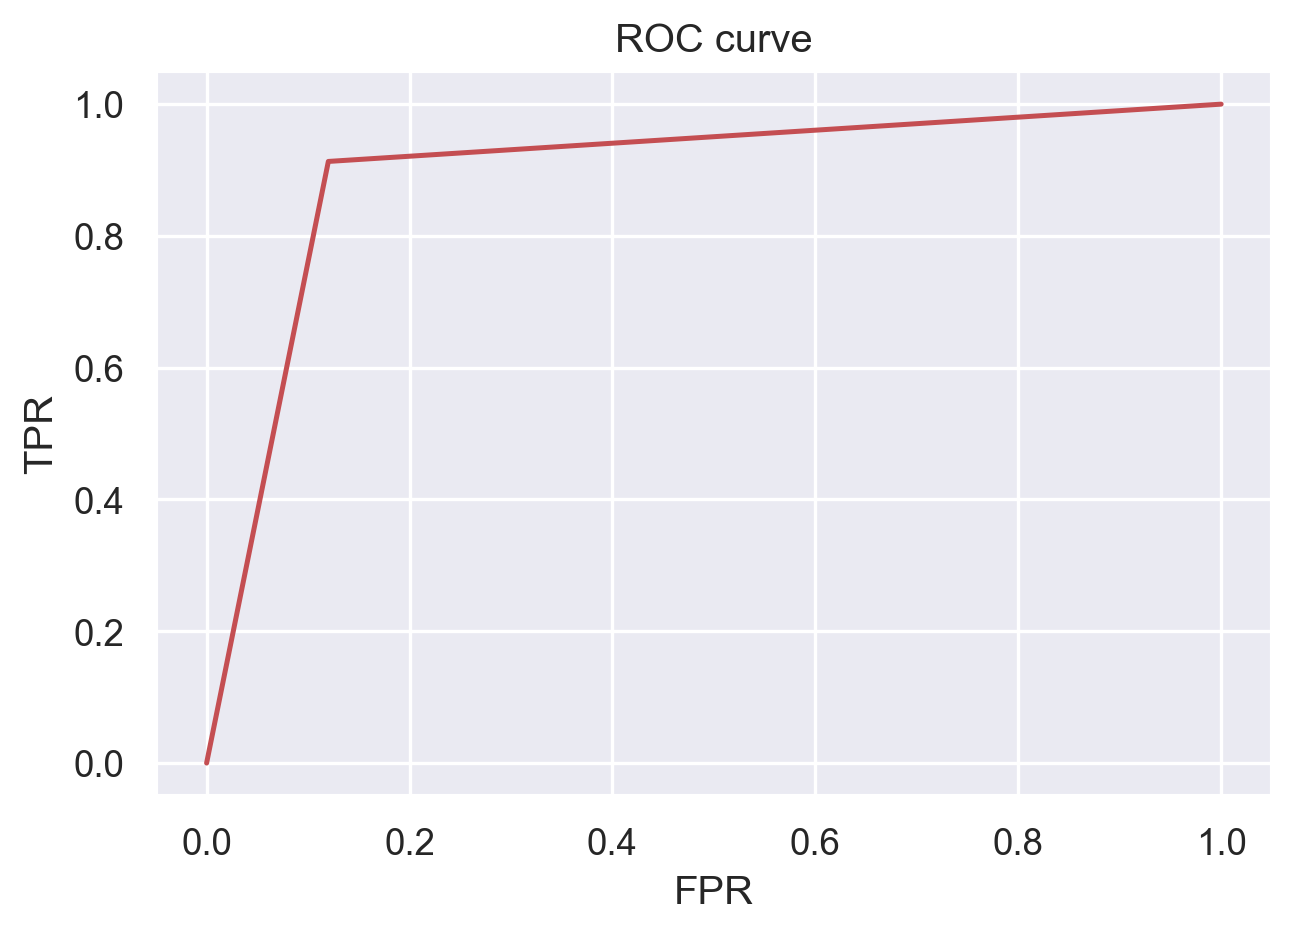

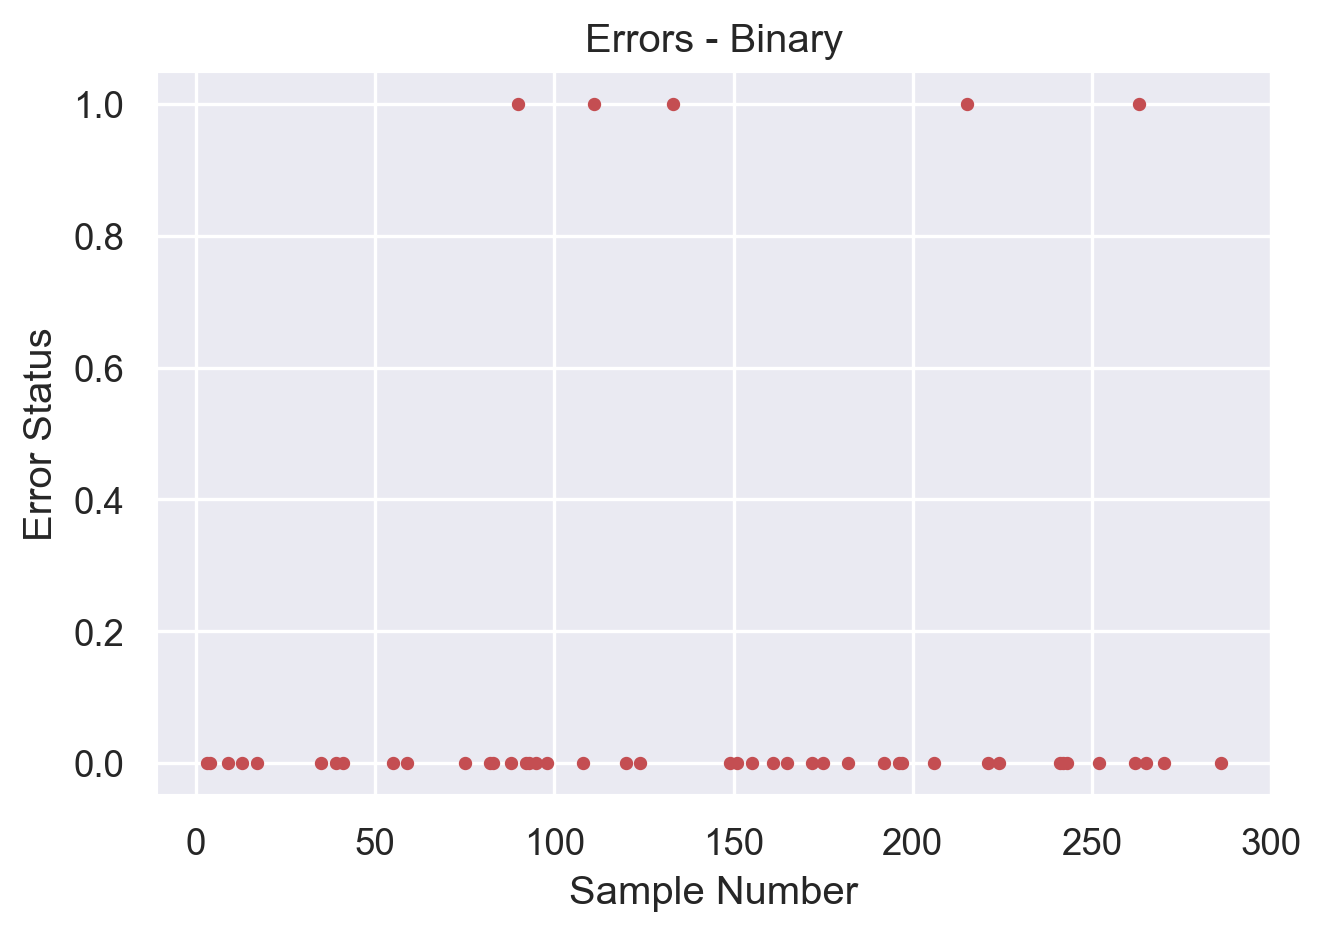

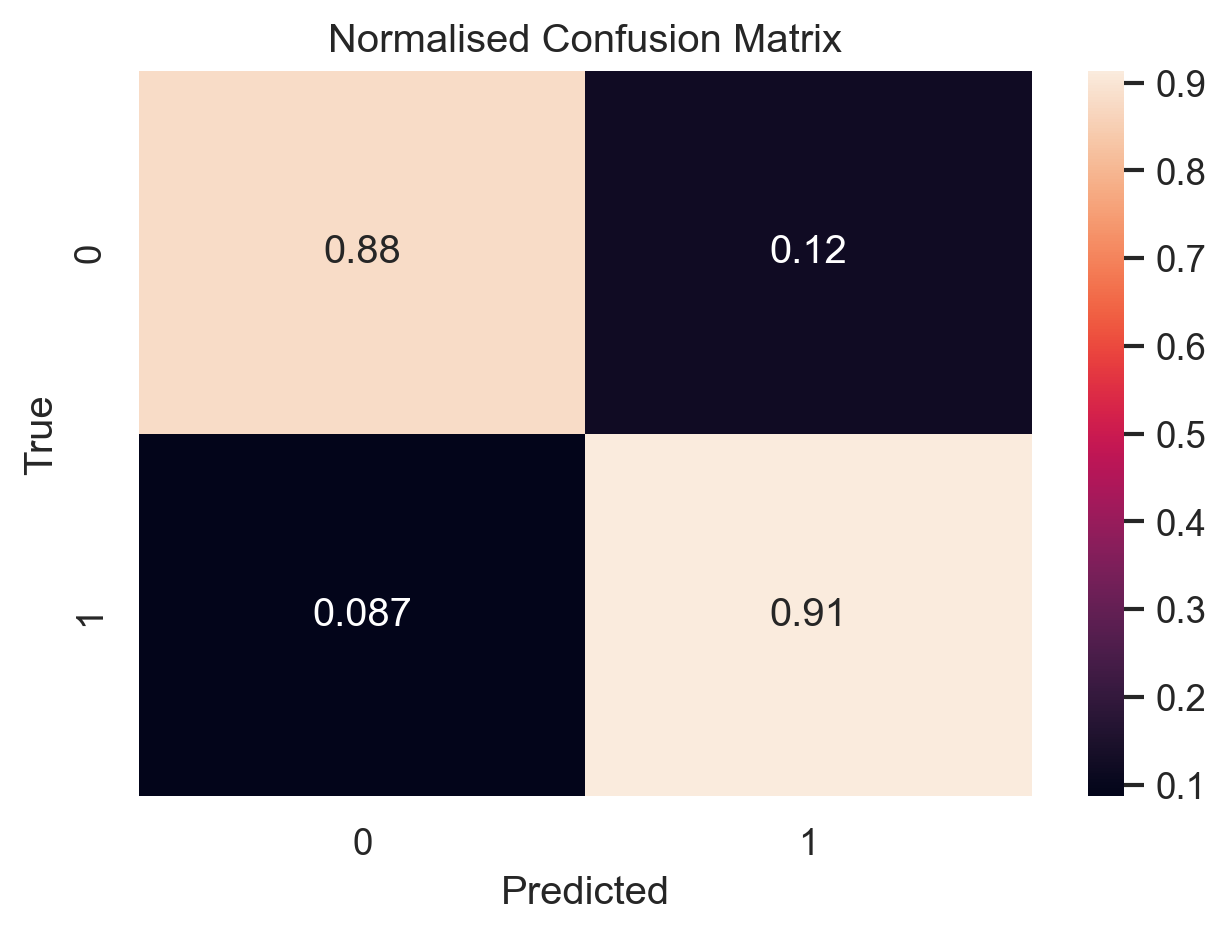

In [31]:
sgd_pipeline = Pipeline([
    ('preprocess', preprocessing_pipeline), 
    ('sgd', SGDClassifier()) 
])

# Train
sgd_pipeline.fit(X_train_without_worst,y_train_without_worst)

# Predict
y_val_pred = sgd_pipeline.predict(X_val_without_worst)

# Display Metric AUC
fpr, tpr, thresholds = roc_curve(y_val_without_worst, y_val_pred, pos_label=1)
print(f'AUC: {auc(fpr, tpr)}')

# ROC curve
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,tpr,'r')
plt.title('ROC curve')
plt.show()

# Error binary
plt.plot(np.abs(y_val_without_worst - y_val_pred),'r.')
plt.xlabel('Sample Number')
plt.ylabel('Error Status')
plt.title('Errors - Binary')
plt.show()

# Confusion matrix
cmat = confusion_matrix(y_true=y_val_without_worst, y_pred=y_val_pred, normalize='true')
sns.heatmap(cmat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

KNN (K-Nearest Neighbour) classifier
Best params for KNN (K-Nearest Neighbour) classifier : {'knn__n_neighbors': 20, 'knn__weights': 'distance'}
AUC: 0.9365217391304348


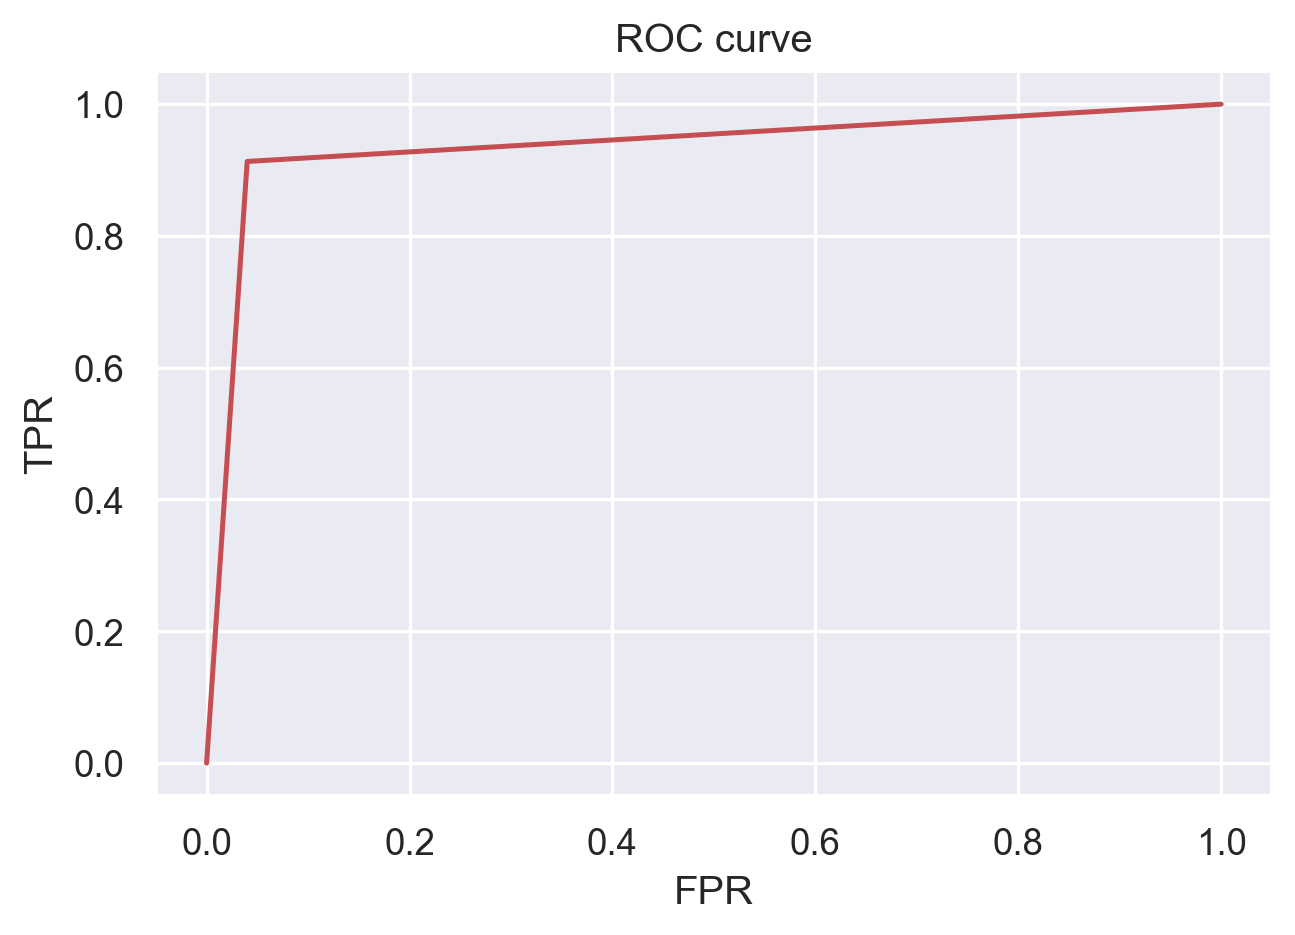

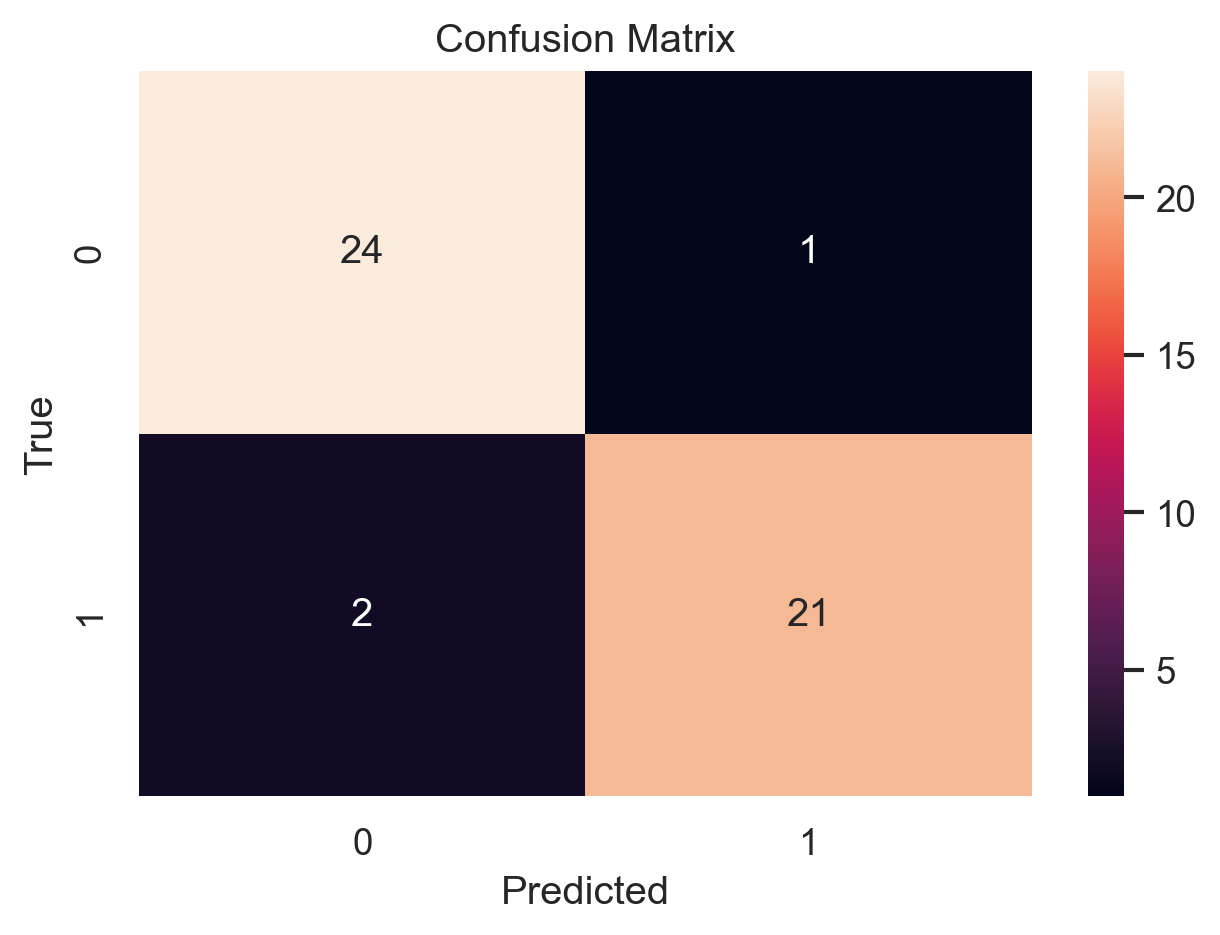


Decision tree classifier
Best params for Decision tree classifier : {'dt__max_depth': 4, 'dt__min_samples_leaf': 7}
AUC: 0.8930434782608696


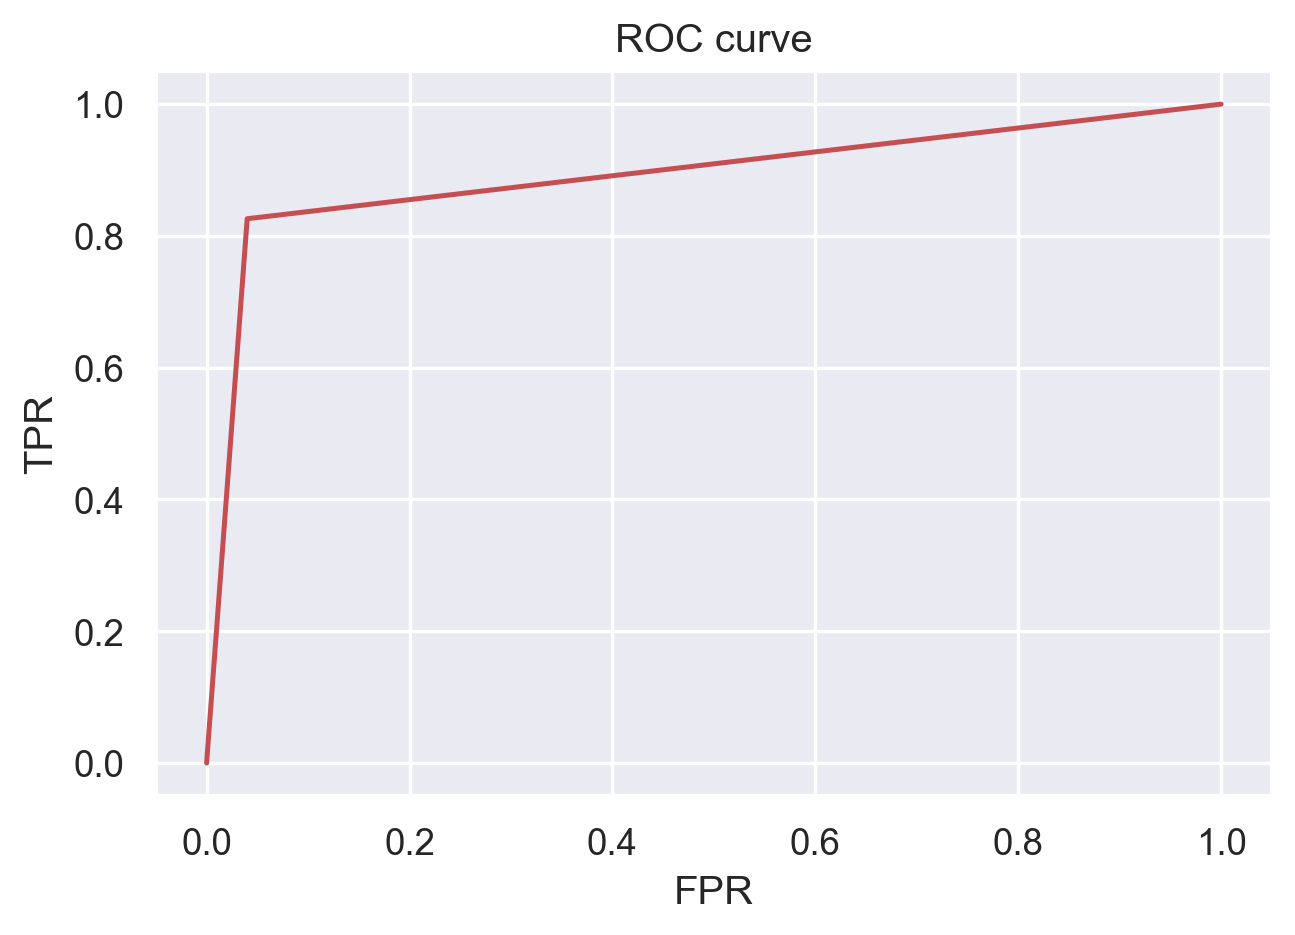

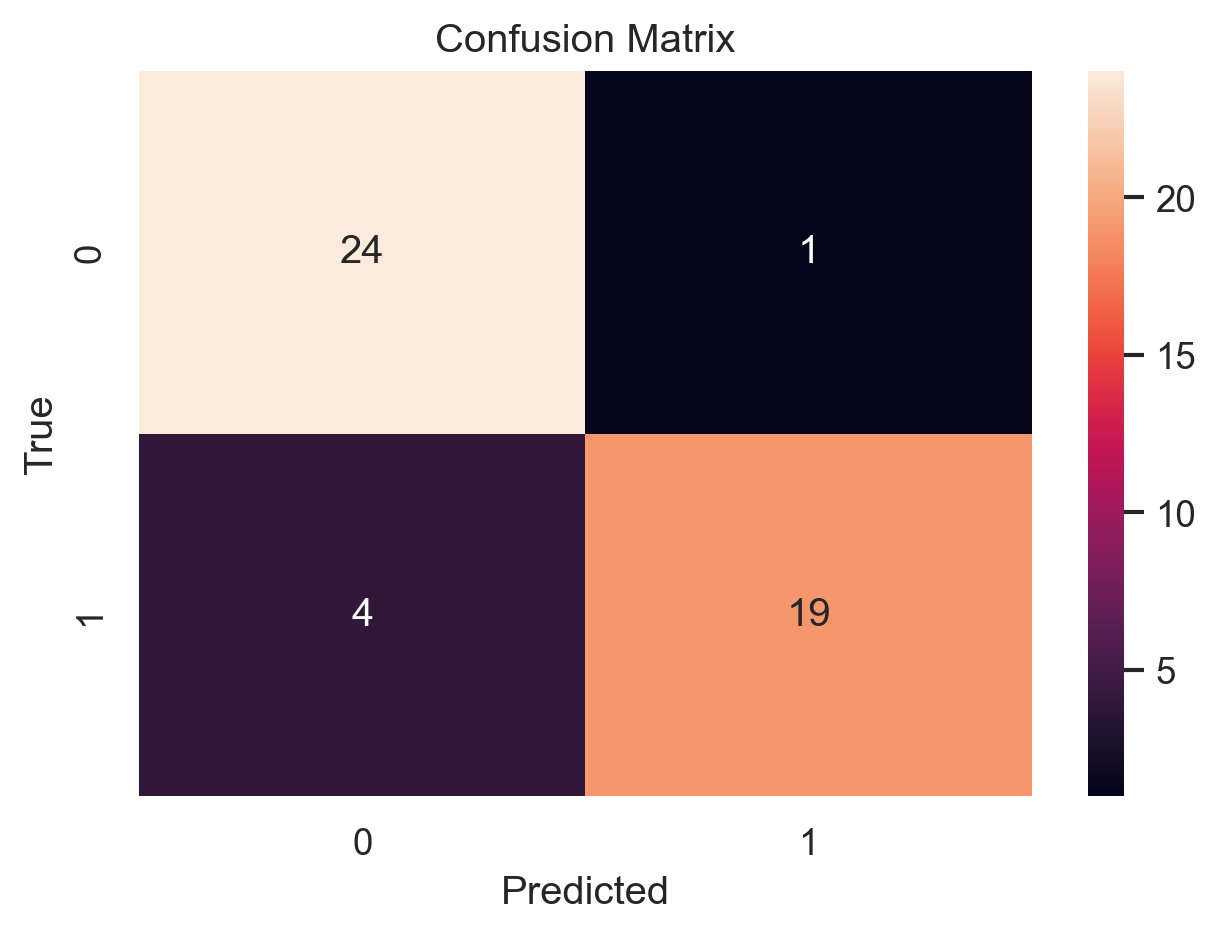


Support vector machine classifier
Best params for Support vector machine classifier : {'svc__kernel': 'rbf'}
AUC: 0.9365217391304348


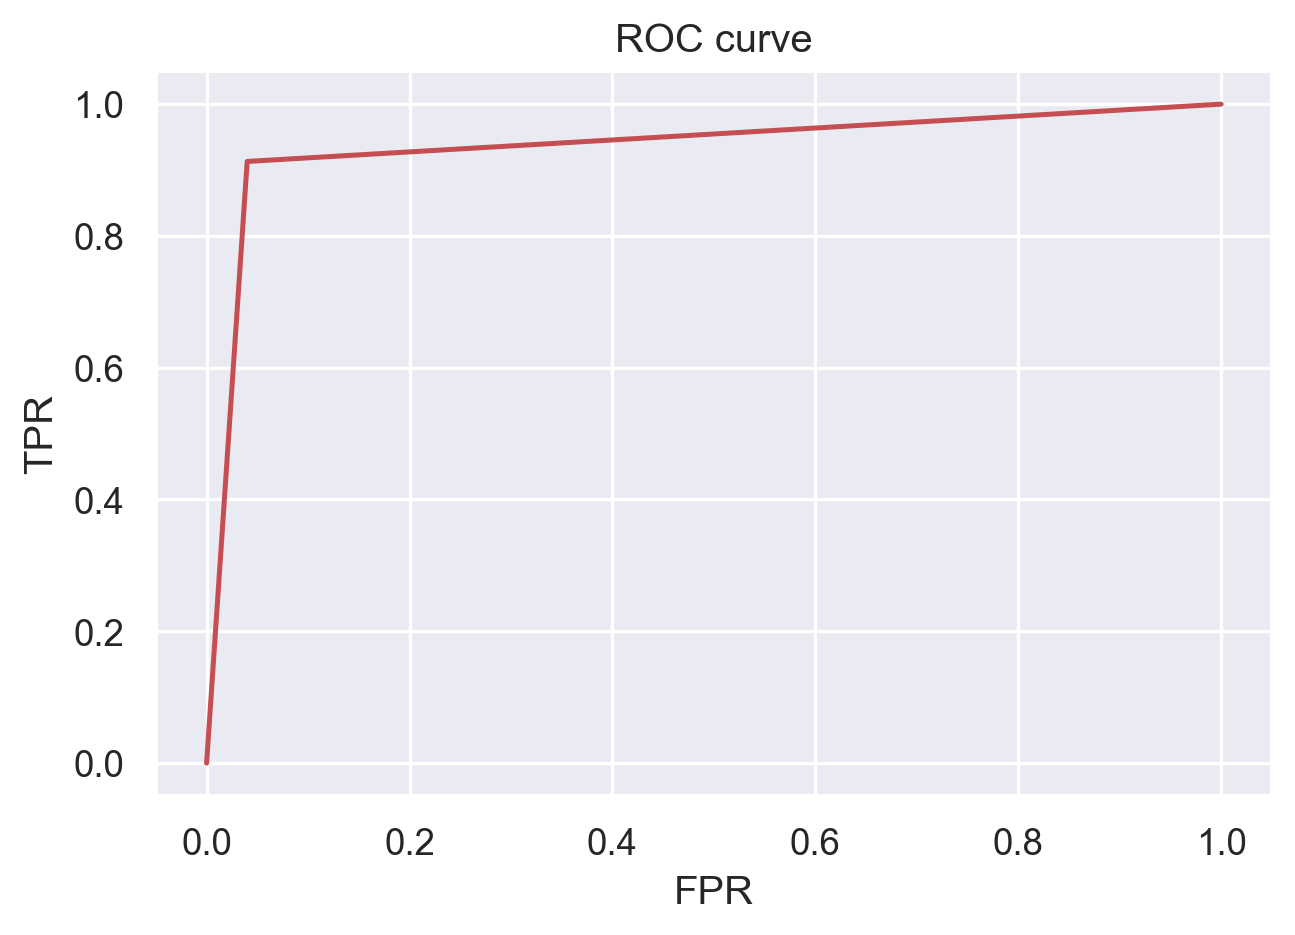

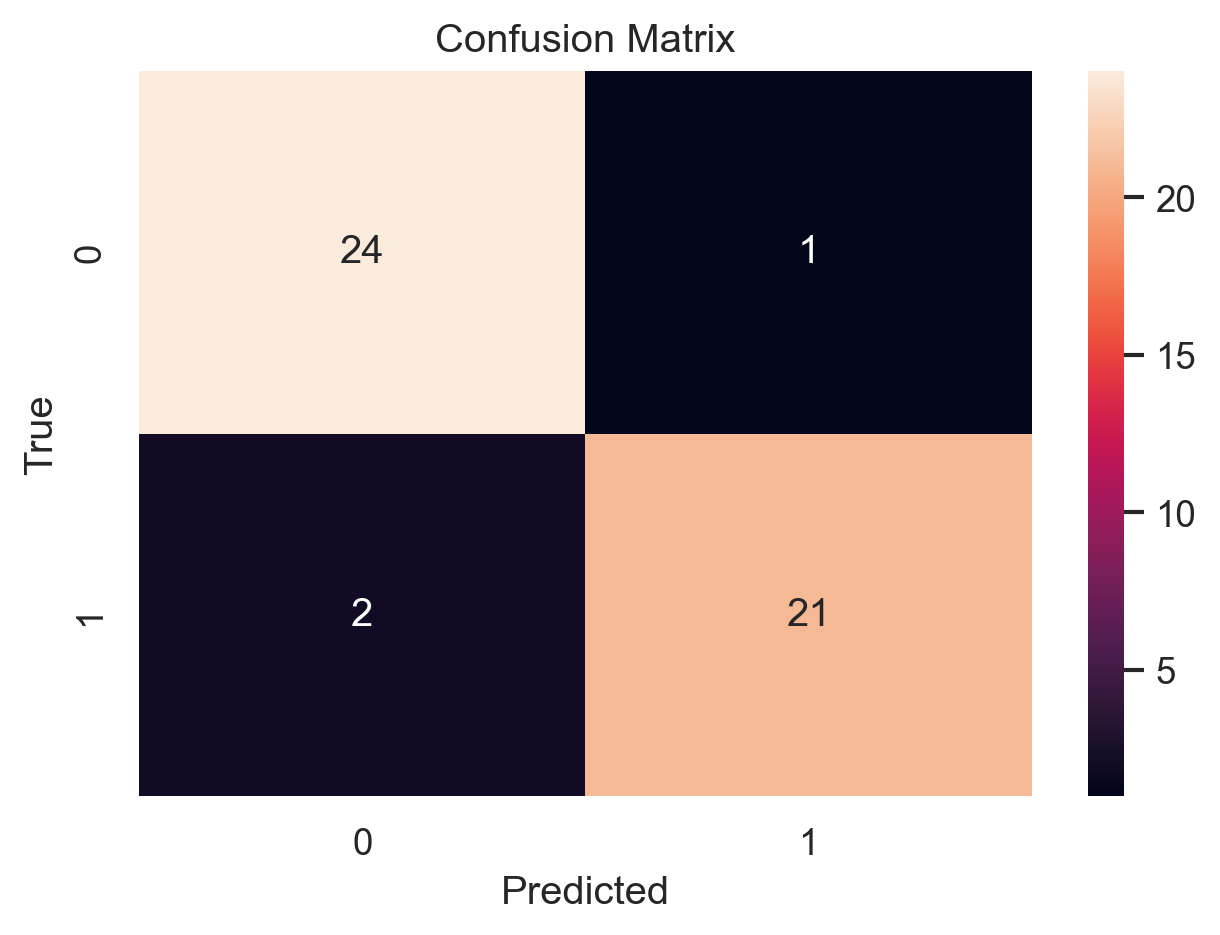


SGD classifier
Best params for SGD classifier : {'sgd__alpha': 0.0001, 'sgd__eta0': 0.1, 'sgd__learning_rate': 'optimal', 'sgd__penalty': 'l2'}
AUC: 0.9565217391304348


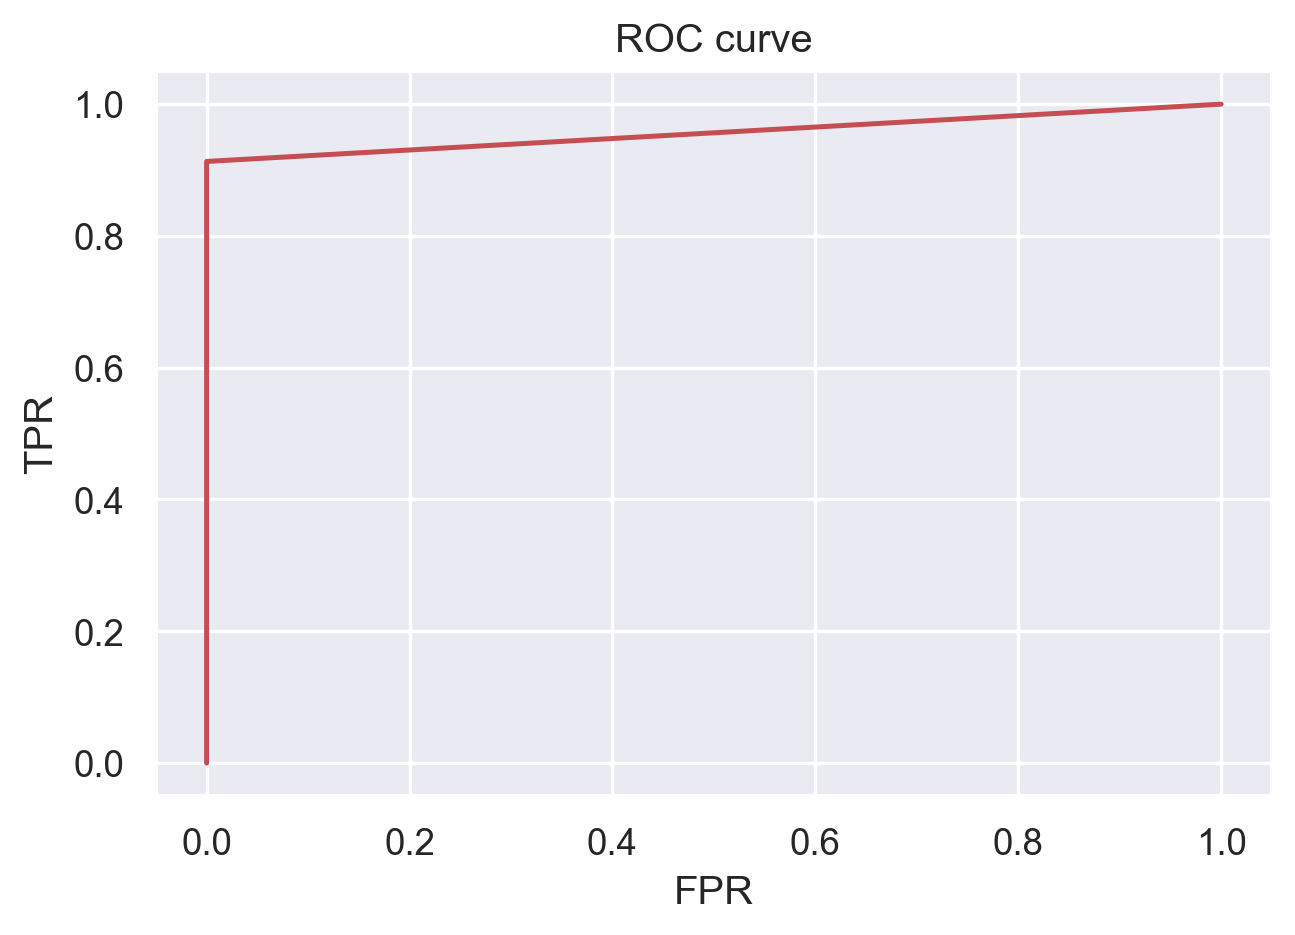

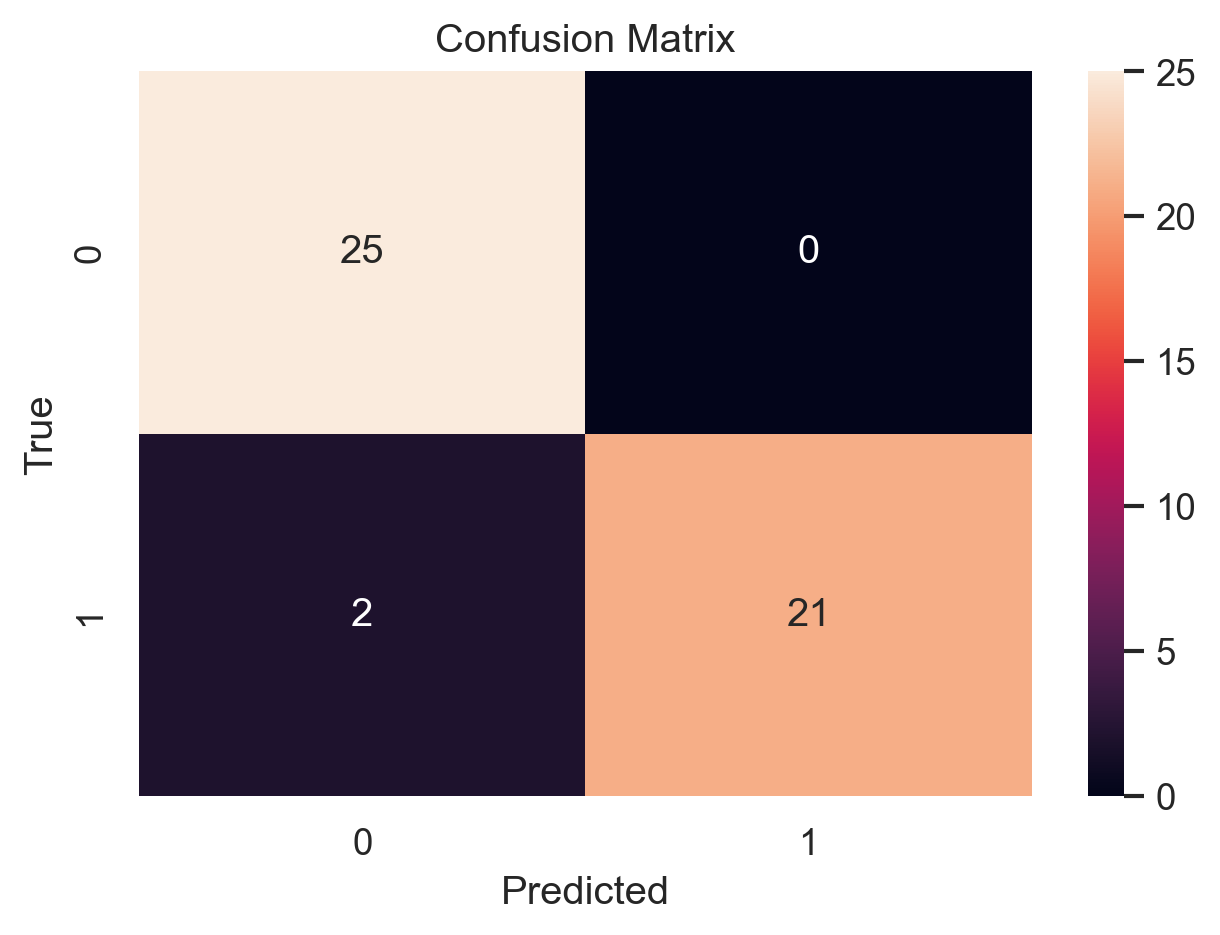

In [32]:
for key, value in dict_models.items():
    pl = value[0]
    params = value[1]
    report_model(pl, params, key, y_val_without_worst)

In [33]:
the_best_model_name = None
the_best_auc = None
for key, value in dict_scores.items():
    if the_best_model_name is None:
        the_best_model_name = key
        the_best_auc = value[0]
    elif the_best_auc < value[0]:
        the_best_model_name = key
        the_best_auc = value[0]
        
    print(f'{key}')
    print(f'\tAUC = {value[0]}')

KNN (K-Nearest Neighbour) classifier
	AUC = 0.9365217391304348
Decision tree classifier
	AUC = 0.8930434782608696
Support vector machine classifier
	AUC = 0.9365217391304348
SGD classifier
	AUC = 0.9565217391304348


In [34]:
print(f"The best model is {the_best_model_name} with AUC = {the_best_auc}")

The best model is SGD classifier with AUC = 0.9565217391304348


hyperparameter settings : {'sgd__alpha': 0.0001, 'sgd__eta0': 0.1, 'sgd__learning_rate': 'optimal', 'sgd__penalty': 'l2'}
Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('sgd', SGDClassifier(eta0=0.1))])
AUC: 0.899888765294772


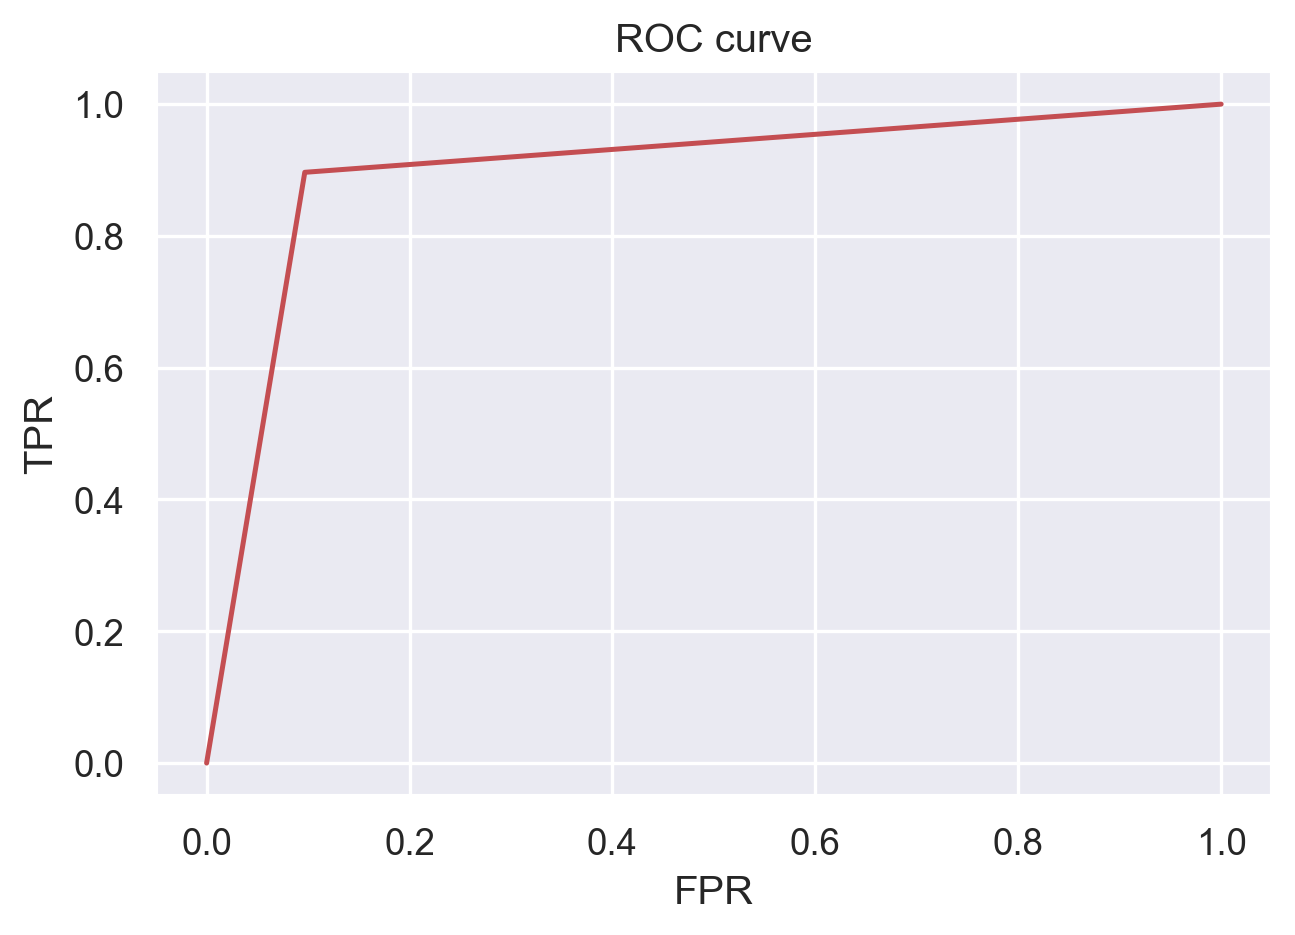

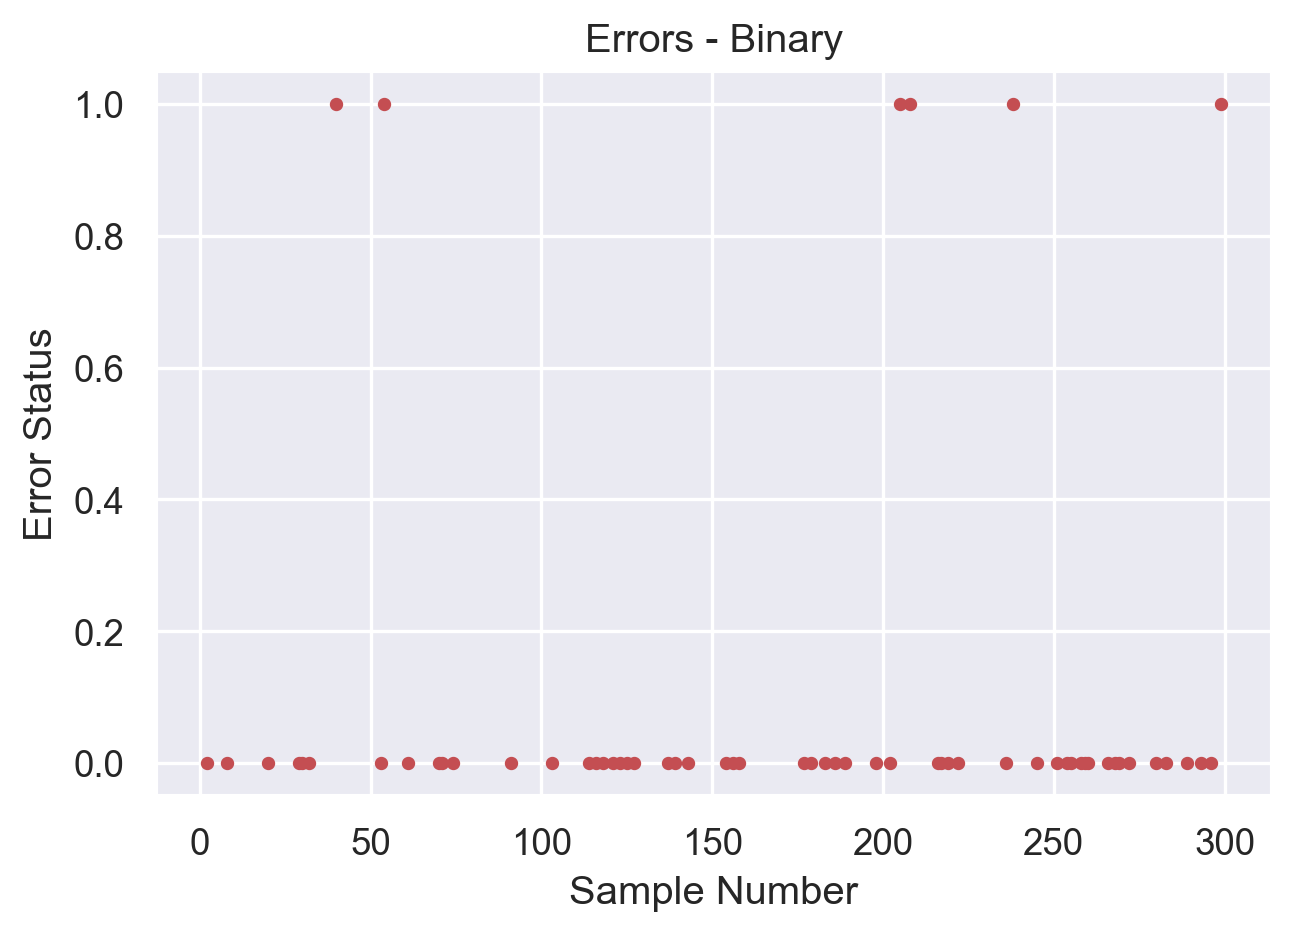

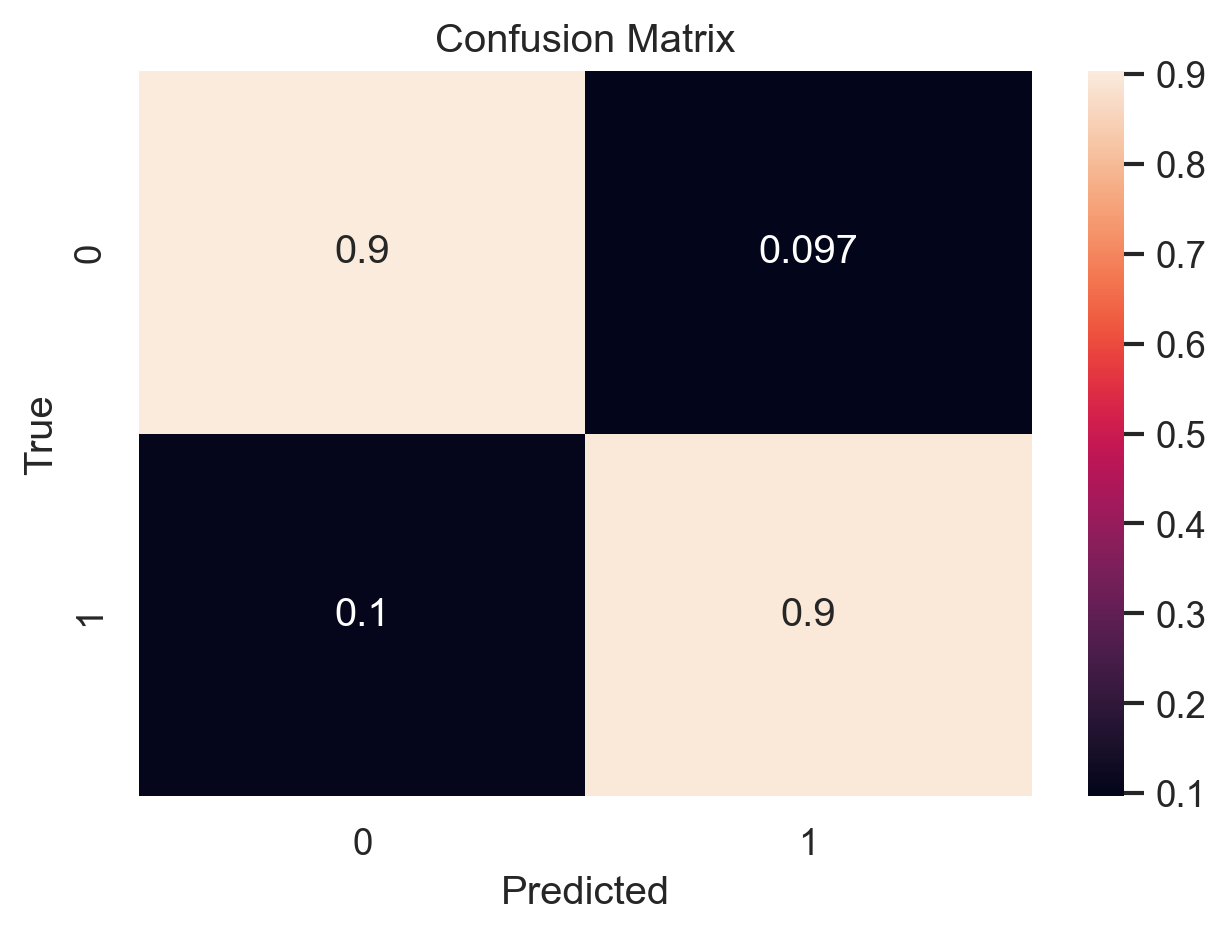

In [35]:
model_score = dict_scores[the_best_model_name]
print(f'hyperparameter settings : {model_score[2]}')

model = model_score[1]
print(model)

# Get the whole training set
X_train_whole_without_worst = bigtrain_set_without_worst.drop("label",axis=1)
y_train_whole_without_worst = bigtrain_set_without_worst["label"].copy()

# Train model
model.fit(X_train_whole_without_worst, y_train_whole_without_worst)

# Predict on test set
y_test_pred = model.predict(X_test_without_worst)
        
# AUC
fpr, tpr, thresholds = roc_curve(y_test_without_worst, y_test_pred, pos_label=1)
print(f'AUC: {auc(fpr, tpr)}')

# ROC curve
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,tpr,'r')
plt.title('ROC curve')
plt.show()

# Error binary
plt.plot(np.abs(y_test_without_worst - y_test_pred),'r.')
plt.xlabel('Sample Number')
plt.ylabel('Error Status')
plt.title('Errors - Binary')
plt.show()

# Calculate and display confusion matrix
cmat = confusion_matrix(y_true=y_test_without_worst, y_pred=y_test_pred, normalize='true')
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 4.2 Performance difference [1 mark]

Do you think the new classifier, that does not use the "worst" features, is:
 - **as good as the previous classifier** (that uses all the features)
 - **better than the previous classifier**
 - **worse than the previous classifier**
 
Give reasons for your answer.

#### Your answer here

1. Compared to the previous classifier, the AUC and recall have decreased slightly and have a recall rate of 90%, which does not stratify any of the client's criteria for at least a 95% probability of recognising the presence of malignant cancer. 
2. The new classifier is worse than the prior classifier, which is fair given that the 'worst features' consist of 10 columns that have a strong correlation for training and prediction. Eliminating these characteristics will diminish the classifier's performance. 
3. Therefore, it is necessary to analyse the trade-off between financial expense and classifier acceptability.